In [2]:
# Import all the necessary modules
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas_datareader as pdr
import math
import datetime
import itertools
import yfinance as yf
import seaborn as sn
from IPython.display import display, HTML
from trend_following import (apply_jupyter_fullscreen_css, load_financial_data, get_returns_volatility, calculate_slope, trend_signal, slope_signal, 
                             create_trend_strategy, get_close_prices, calculate_donchian_channels)
from strategy_performance_metrics import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
import coinbase_utils as cn
import strategy_performance_metrics as perf
import trend_following as tf
%matplotlib inline

In [4]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)

<module 'trend_following' from '/Users/adheerchauhan/Documents/git/trend_following/trend_following.py'>

In [6]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

In [8]:
def save_historical_crypto_prices_from_coinbase_temp(ticker, end_date, save_to_file=False):

    client = cn.get_coinbase_rest_api_client(cn.key_location)
    start_date_dict = {
        'BTC-USD': '2016-01-01',
        'ETH-USD': '2016-05-01',
        'SOL-USD': '2021-06-01',
        'LTC-USD': '2021-08-01',
        'DOGE-USD': '2021-05-01',
        'CRO-USD': '2021-10-01',
        'ADA-USD': '2021-03-01',
        'AVAX-USD': '2021-09-01',
        'XRP-USD': '2023-06-01',
        'SHIB-USD': '2021-08-01',
        'LINK-USD': '2019-06-01',
        'UNI-USD': '2020-09-01',
    }
    start_date = start_date_dict.get(ticker)
    if not start_date:
        print(f"Start date for {ticker} is not included in the dictionary!")
        return None

    start_date = pd.Timestamp(start_date)
    temp_start_date = start_date
    end_date = pd.Timestamp(end_date)
    current_end_date = temp_start_date
    crypto_price_list = []
    while current_end_date < end_date:
        current_end_date = pd.to_datetime(temp_start_date) + datetime.timedelta(weeks=6)
        if current_end_date > end_date:
            current_end_date = end_date
        start_timestamp = int(temp_start_date.timestamp())
        end_timestamp = int(current_end_date.timestamp())
        # print(temp_start_date, current_end_date, end_date)
        crypto_price_list.append(
            cn.get_coinbase_daily_historical_price_data(client, ticker, start_timestamp, end_timestamp))
        temp_start_date = pd.to_datetime(current_end_date) + datetime.timedelta(days=1)

    df = pd.concat(crypto_price_list, axis=0)

    if save_to_file:
        filename = f"{ticker}-pickle-{start_date.strftime('%Y-%m-%d')}-{end_date.strftime('%Y-%m-%d')}"
        output_file = f'coinbase_historical_price_folder/{filename}'
        df.to_pickle(output_file)

    return df

In [10]:
end_date = datetime.datetime.now().date()#.strftime('%Y-%m-%d')

In [12]:
df = save_historical_crypto_prices_from_coinbase_temp(ticker='BTC-USD', end_date=end_date, save_to_file=False)
# df = (df[['close']].rename(columns={'close':ticker}))
# df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]

In [13]:
df.tail()

low      high      open     close        volume
date                                                            
2024-11-11  80277.34  89666.00  80427.69  88770.73  35560.118667
2024-11-12  85010.00  90100.00  88770.74  88035.43  40109.932529
2024-11-13  86220.50  93495.00  88035.43  90493.82  42318.690917
2024-11-14  86672.07  91831.25  90499.40  87340.40  23153.470435
2024-11-15  87100.83  90702.12  87338.96  88643.90   9806.647151

In [14]:
df.tail()

low      high      open     close        volume
date                                                            
2024-11-11  80277.34  89666.00  80427.69  88770.73  35560.118667
2024-11-12  85010.00  90100.00  88770.74  88035.43  40109.932529
2024-11-13  86220.50  93495.00  88035.43  90493.82  42318.690917
2024-11-14  86672.07  91831.25  90499.40  87340.40  23153.470435
2024-11-15  87100.83  90702.12  87338.96  88643.90   9806.647151

In [414]:
df_btc = df.copy()

In [37]:
df_test = cn.get_coinbase_ohlc_data(ticker=ticker)

In [43]:
df_test.index[0]

datetime.date(2016, 1, 1)

In [35]:
df.index[0]#.head()

datetime.date(2016, 1, 1)

In [12]:
## Trend Following Strategy with Moving Average Crossovers and Donchian Channels
def generate_trend_signal_with_donchian_channel(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, moving_avg_type='exponential', price_or_returns_calc='returns',
                                                rolling_donchian_window=20, include_signal_strength=True, long_only=False, use_coinbase_data=True):
    
    # Generate Trend Signal
    if use_coinbase_data:
        # df = cn.get_coinbase_ohlc_data(ticker=ticker)
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, end_date=end_date, save_to_file=False)
        df = (df[['close']].rename(columns={'close':ticker}))
        df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
    else:
        df = get_close_prices(start_date, end_date, ticker, print_status=False)
    df_trend = (create_trend_strategy(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize, slope_window=10, moving_avg_type=moving_avg_type,
                                      price_or_returns_calc=price_or_returns_calc)
                .rename(columns={f'{ticker}_trend_strategy_returns': f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}',
                                 f'{ticker}_trend_strategy_trades': f'{ticker}_trend_strategy_trades_{fast_mavg}_{mavg_stepsize}_{slow_mavg}'}))
    # Generate Donchian Signal
    df_donchian = generate_donchian_channels(start_date=start_date, end_date=end_date, ticker=ticker, price_or_returns_calc=price_or_returns_calc,
                                             rolling_donchian_window=rolling_donchian_window, use_coinbase_data=use_coinbase_data)
    if price_or_returns_calc == 'price':

        # Buy signal: Price crosses above upper band
        df_donchian[f'{ticker}_{rolling_donchian_window}_donchian_signal'] = np.where(
            (df_donchian[f'close'] > df_donchian[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_price']), 1,
            np.where((df_donchian[f'close'] < df_donchian[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_price']), -1, 0))
    elif price_or_returns_calc == 'returns':
        df_donchian[f'{ticker}_{rolling_donchian_window}_donchian_signal'] = np.where(
            (df_donchian[f'{ticker}_pct_returns'] > df_donchian[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_returns']), 1,
            np.where((df_donchian[f'{ticker}_pct_returns'] < df_donchian[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_returns']), -1, 0))

    # Merging the Trend and donchian Dataframes
    donchian_cols = [f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}', f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}',
                     f'{ticker}_{rolling_donchian_window}_donchian_middle_band_{price_or_returns_calc}', f'{ticker}_{rolling_donchian_window}_donchian_signal']
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')
    
    if include_signal_strength:
        # Calculate the strength of moving average crossover and donchian signal
        df_trend[f'{ticker}_donchian_band_width_{price_or_returns_calc}'] = (df_trend[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'] -
                                                                            df_trend[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}'])
        donchian_strength = (np.abs(df_trend[f'{ticker}'] - df_trend[f'{ticker}_{rolling_donchian_window}_donchian_middle_band_{price_or_returns_calc}']) /
                            df_trend[f'{ticker}_donchian_band_width_{price_or_returns_calc}'])
        crossover_strength = np.abs(df_trend[f'{ticker}_{fast_mavg}_mavg'] - df_trend[f'{ticker}_{slow_mavg}_mavg']) / df_trend[f'{ticker}']

        df_trend[f'{ticker}_crossover_donchian_signal_strength'] = (donchian_strength + crossover_strength) / 2
        strength_threshold = 0.5
    
        # Moving Average and Donchian Channel Signal
        buy_signal = ((df_trend[f'{ticker}_{rolling_donchian_window}_donchian_signal'] == 1) &
                      (df_trend[f'{ticker}_trend_signal'] == 1) &
                      (df_trend[f'{ticker}_crossover_donchian_signal_strength'] > strength_threshold))
        sell_signal = ((df_trend[f'{ticker}_{rolling_donchian_window}_donchian_signal'] == -1) &
                       (df_trend[f'{ticker}_trend_signal'] == -1) &
                       ((df_trend[f'{ticker}_crossover_donchian_signal_strength'] > strength_threshold)))
    else:
        # Moving Average and Donchian Channel Signal
        buy_signal = ((df_trend[f'{ticker}_{rolling_donchian_window}_donchian_signal'] == 1) &
                      (df_trend[f'{ticker}_trend_signal'] == 1))
        sell_signal = ((df_trend[f'{ticker}_{rolling_donchian_window}_donchian_signal'] == -1) &
                       (df_trend[f'{ticker}_trend_signal'] == -1))
    
    if long_only:
        df_trend[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'] = (
            np.where(buy_signal, 1, 0))
    else:
        df_trend[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'] = (
            np.where(buy_signal, 1, np.where(sell_signal, -1, 0)))
        
    df_trend[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'] = (
        df_trend[(f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal')] * 
        df_trend[f'{ticker}_pct_returns'])
    df_trend[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'] = (
        df_trend[(f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal')].diff())
    
    return df_trend

def generate_donchian_channels(start_date, end_date, ticker, price_or_returns_calc='price',
                               rolling_donchian_window=20, use_coinbase_data=True):
    if use_coinbase_data:
        # df = cn.get_coinbase_ohlc_data(ticker=ticker)
        # df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, end_date=end_date, save_to_file=False)
        # df = (df[['close']].rename(columns={'close':ticker}))
        df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
    else:
        df = load_financial_data(start_date, end_date, ticker, print_status=False)  # .shift(1)
        df.columns = ['open', 'high', 'low', 'close', 'adjclose', 'volume']

    if price_or_returns_calc == 'price':
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'] = (
            df[f'close'].rolling(window=rolling_donchian_window).max())

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}'] = (
            df[f'close'].rolling(window=rolling_donchian_window).min())

    elif price_or_returns_calc == 'returns':
        # Calculate Percent Returns
        df[f'{ticker}_pct_returns'] = df[f'close'].pct_change()

        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=rolling_donchian_window).max()

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=rolling_donchian_window).min()

    # Middle of the channel (optional, could be just average of upper and lower)
    df[f'{ticker}_{rolling_donchian_window}_donchian_middle_band_{price_or_returns_calc}'] = (
            (df[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'] +
             df[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}']) / 2)

    # Shift only the Keltner channel metrics to avoid look-ahead bias
    df[[f'{ticker}_{rolling_donchian_window}_donchian_middle_band_{price_or_returns_calc}',
        f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}',
        f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}']] = df[[
        f'{ticker}_{rolling_donchian_window}_donchian_middle_band_{price_or_returns_calc}',
        f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}',
        f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}']].shift(1)

    return df

In [14]:
def plot_trend_following_performance(df, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, rolling_sharpe_window):
    
    start_date = pd.to_datetime(start_date).date().strftime('%Y-%m-%d')
    end_date = pd.to_datetime(end_date).date().strftime('%Y-%m-%d')
    fig = plt.figure(figsize=(22,20))
    layout = (5,2)
    trend_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    trend_donchian_ax = plt.subplot2grid(layout, (1,0), colspan=2)
    trend_signal_ax = plt.subplot2grid(layout, (2,0), colspan=2)
    trend_rolling_sharpe_ax = plt.subplot2grid(layout, (3,0), colspan=2)
    trend_return_ax = plt.subplot2grid(layout, (4,0))#, colspan=2)
    trend_cum_return_ax = plt.subplot2grid(layout, (4,1))#, colspan=2)

    if price_or_returns_calc == 'price':
        _ = trend_ax.plot(df.index, df[f'{ticker}'], label='Price')
    elif price_or_returns_calc == 'returns':
        _ = trend_ax.plot(df.index, df[f'{ticker}_pct_returns'], label='Returns')
    for mavg in np.linspace(fast_mavg, slow_mavg, mavg_stepsize):
        _ = trend_ax.plot(df.index, df[f'{ticker}_{int(mavg)}_mavg'], label=f'{mavg} M Avg')

    _ = trend_ax.set_title(f'{ticker} Moving Average Ribbons - {start_date} - {end_date}')
    _ = trend_ax.set_ylabel('Price')
    _ = trend_ax.set_xlabel('Date')
    _ = trend_ax.legend()

    if price_or_returns_calc == 'price':
        _ = trend_donchian_ax.plot(df.index, df[f'{ticker}'], label='Price')
    elif price_or_returns_calc == 'returns':
        _ = trend_donchian_ax.plot(df.index, df[f'{ticker}_pct_returns'], label='Returns')
    _ = trend_donchian_ax.plot(df.index,
                      df[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'], label='Donchian Upper Band', linestyle='--', linewidth=3)
    _ = trend_donchian_ax.plot(df.index,
                      df[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}'], label='Donchian Lower Band', linestyle='--', linewidth=3)

    _ = trend_donchian_ax.set_title(f'{ticker} Donchian Channels')
    _ = trend_donchian_ax.set_ylabel('Price')
    _ = trend_donchian_ax.set_xlabel('Date')
    _ = trend_donchian_ax.legend()

    _ = trend_signal_ax.plot(df.index,
                             df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'], label='Signal')
    _ = trend_signal_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Signal')
    _ = trend_signal_ax.set_ylabel('Signal')
    _ = trend_signal_ax.set_xlabel('Date')
    _ = trend_signal_ax.legend()

    _ = trend_rolling_sharpe_ax.plot(df.index,
                                     df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_rolling_sharpe_{rolling_sharpe_window}'],
                                     label='Sharpe Ratio', color='orange')
    _ = trend_rolling_sharpe_ax.set_title(f'{ticker} Rolling Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_ylabel('Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_xlabel('Date')
    _ = trend_rolling_sharpe_ax.legend()

    _ = trend_return_ax.plot(df.index,
                             df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'],
                             label='Return')
    _ = trend_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Return')
    _ = trend_return_ax.set_ylabel('Return')
    _ = trend_return_ax.set_xlabel('Date')
    _ = trend_return_ax.legend()

    # _ = trend_cum_return_ax.plot(df_trend_mavg_donchian.index, df_trend_mavg_donchian[f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_cum'], label='Cum. Return')
    _ = trend_cum_return_ax.plot(df.index, df['strategy_cumulative_return'], label='Cum. Return')
    _ = trend_cum_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Cumulative Return')
    _ = trend_cum_return_ax.set_ylabel('Cum. Return')
    _ = trend_cum_return_ax.set_xlabel('Date')
    _ = trend_cum_return_ax.legend()


    plt.tight_layout()
    
    return

def get_trend_following_strategy_performance(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, rolling_sharpe_window, long_only=False,
                                             include_transaction_costs_and_fees=True, transaction_cost_est=0.001, passive_trade_rate=0.5, use_coinbase_data=True):
    price_or_returns_calc = 'price'
    df = generate_trend_signal_with_donchian_channel(start_date, end_date, ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                                                     mavg_stepsize=mavg_stepsize, price_or_returns_calc=price_or_returns_calc, rolling_donchian_window=rolling_donchian_window,
                                                     include_signal_strength=False, long_only=long_only, use_coinbase_data=use_coinbase_data)
    if include_transaction_costs_and_fees:
        average_fee_per_trade = estimate_fee_per_trade(passive_trade_rate=passive_trade_rate)
        adjusted_daily_returns = df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'] - (
            np.abs(df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades']) * (transaction_cost_est + average_fee_per_trade))
        df['strategy_cumulative_return'] = (1 + adjusted_daily_returns).cumprod() - 1
    else:
        df['strategy_cumulative_return'] = (1 + df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns']).cumprod() - 1

    df[f'rolling_sharpe_{rolling_sharpe_window}'] = (perf.rolling_sharpe_ratio(df, window=rolling_sharpe_window, 
    strategy_daily_return_col=f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',
    strategy_trade_count_col=f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'))
    df = df.rename(
        columns={f'rolling_sharpe_{rolling_sharpe_window}': f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_rolling_sharpe_{rolling_sharpe_window}'})
    
    plot_trend_following_performance(df, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, rolling_sharpe_window)
    
    return df

In [17]:
datetime.datetime.now().date().strftime('%Y-%m-%d')

'2024-11-15'

In [16]:
## Strategy Parameters
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20

In [18]:
datetime.datetime.now().date()

datetime.date(2024, 11, 16)

BTC-USD
ETH-USD
SOL-USD
LTC-USD
DOGE-USD
CRO-USD
ADA-USD
AVAX-USD
XRP-USD
SHIB-USD
LINK-USD
UNI-USD


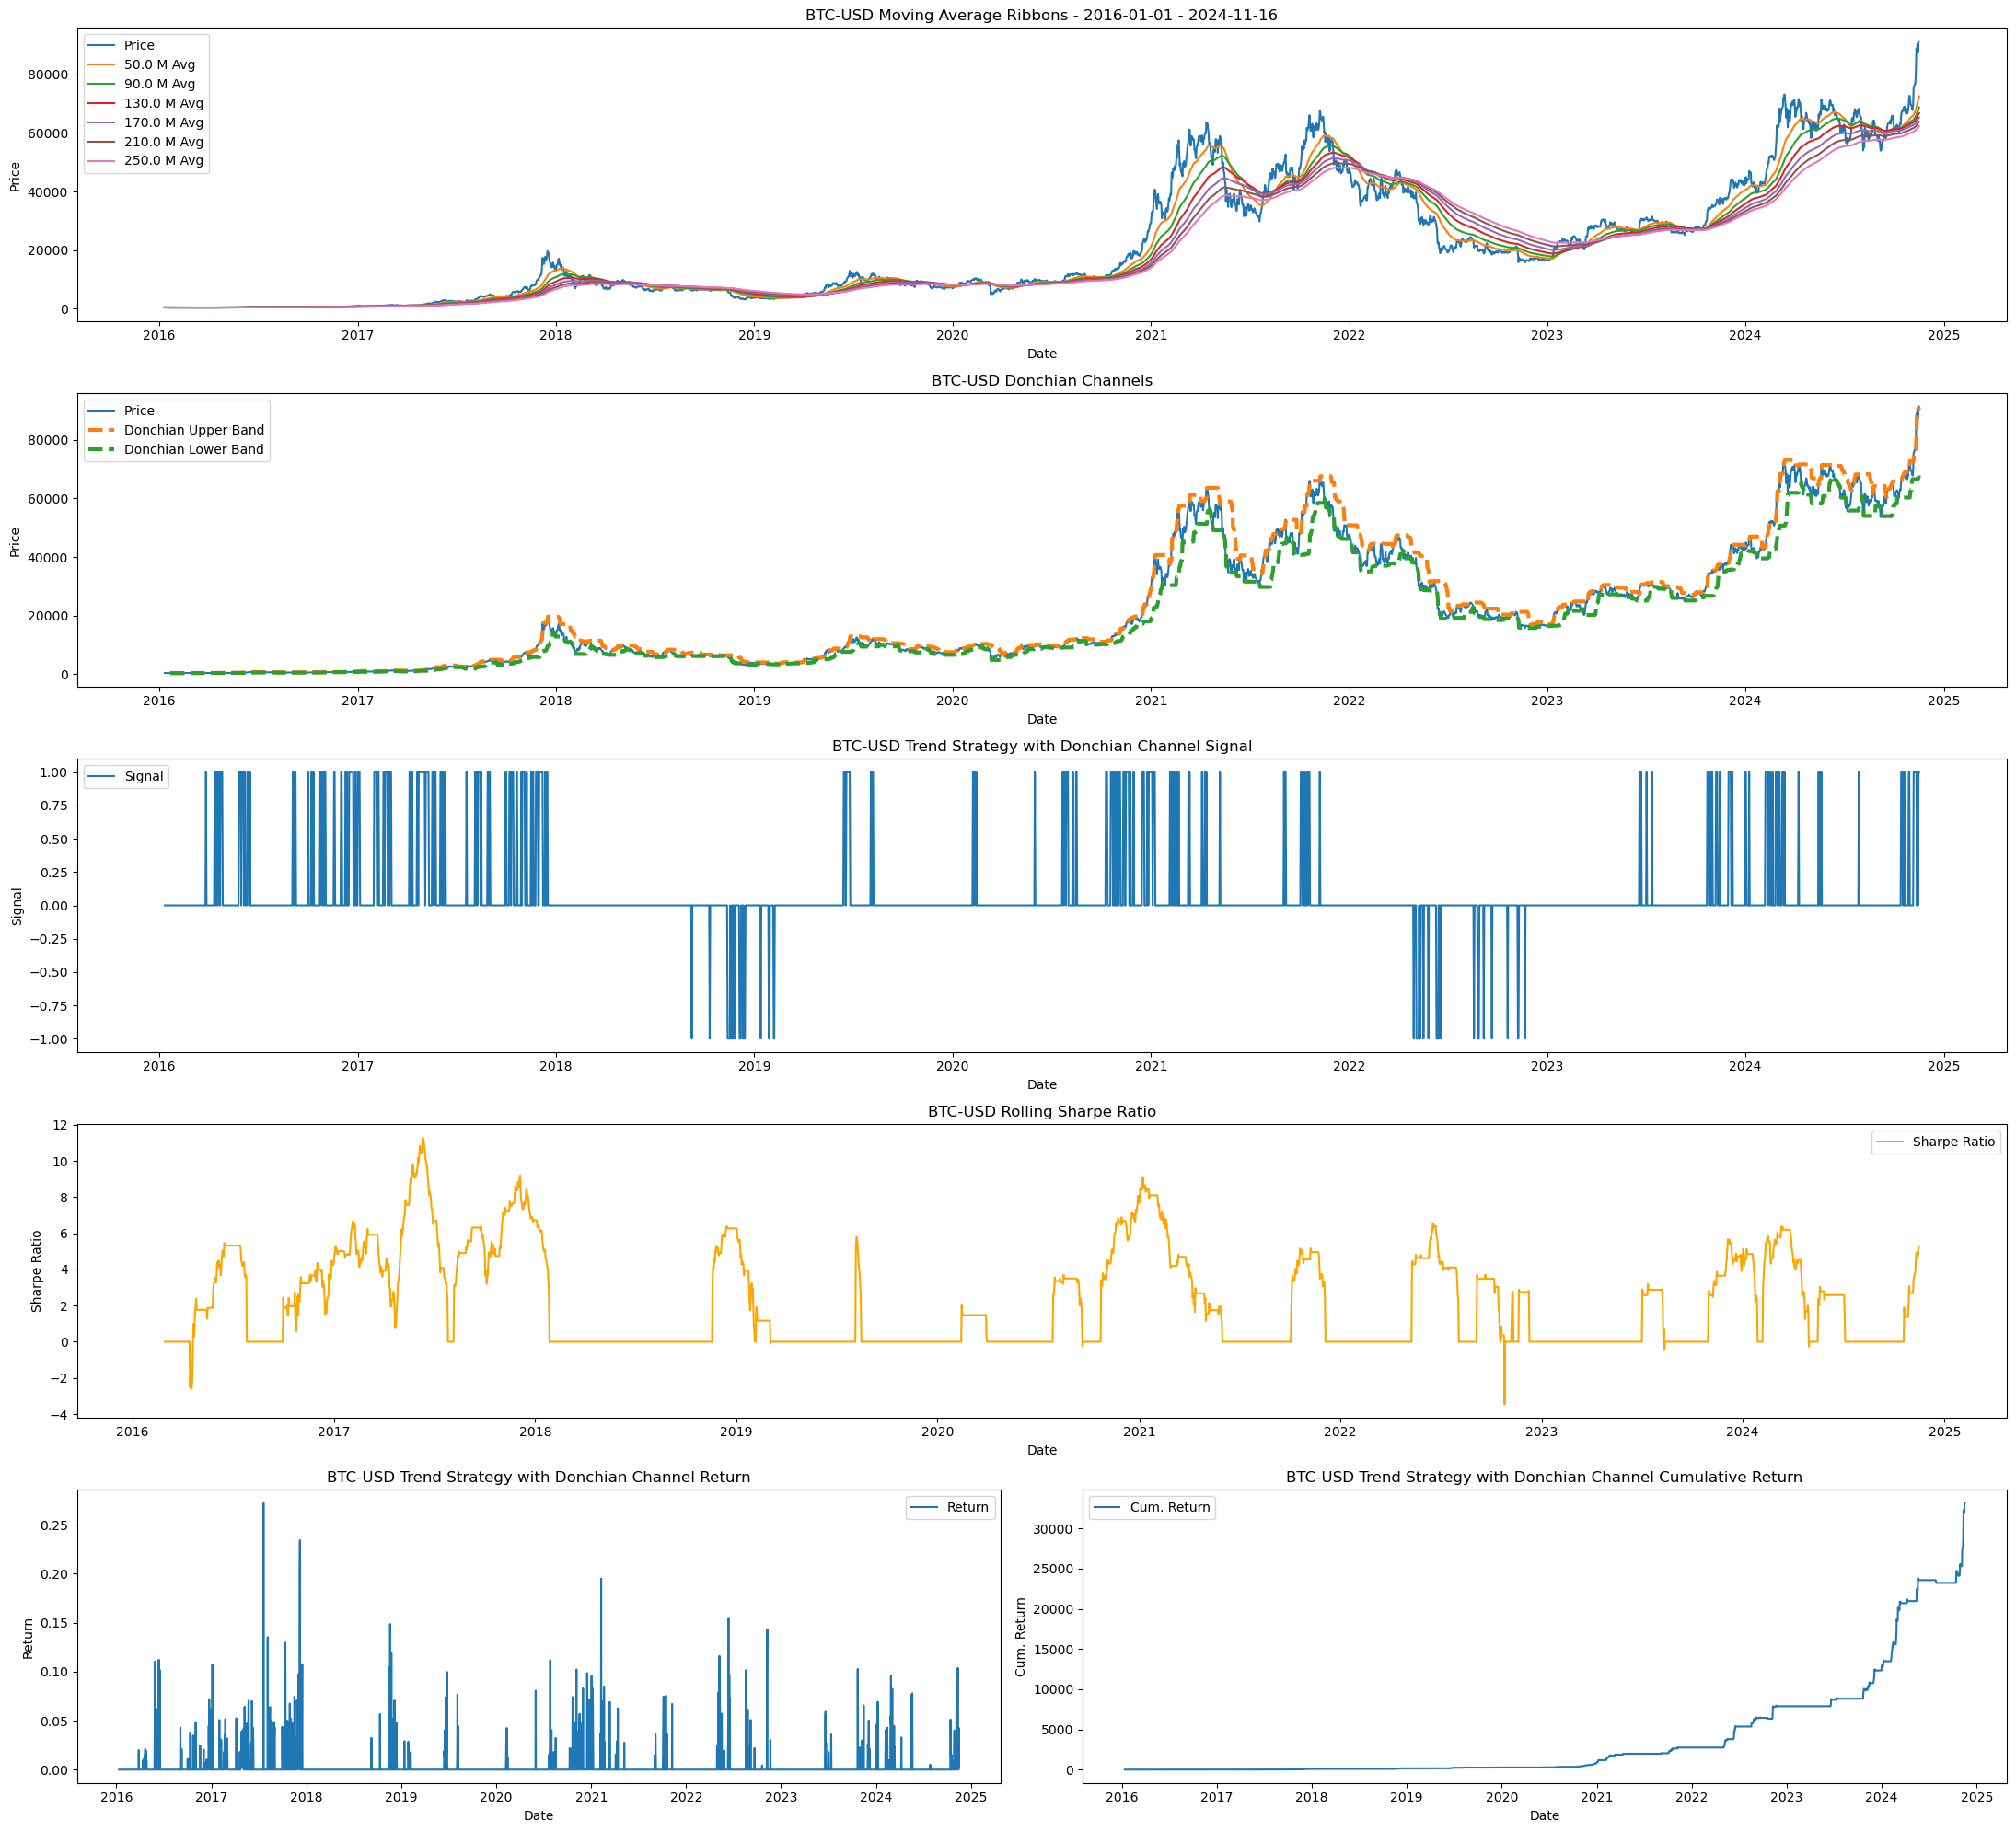

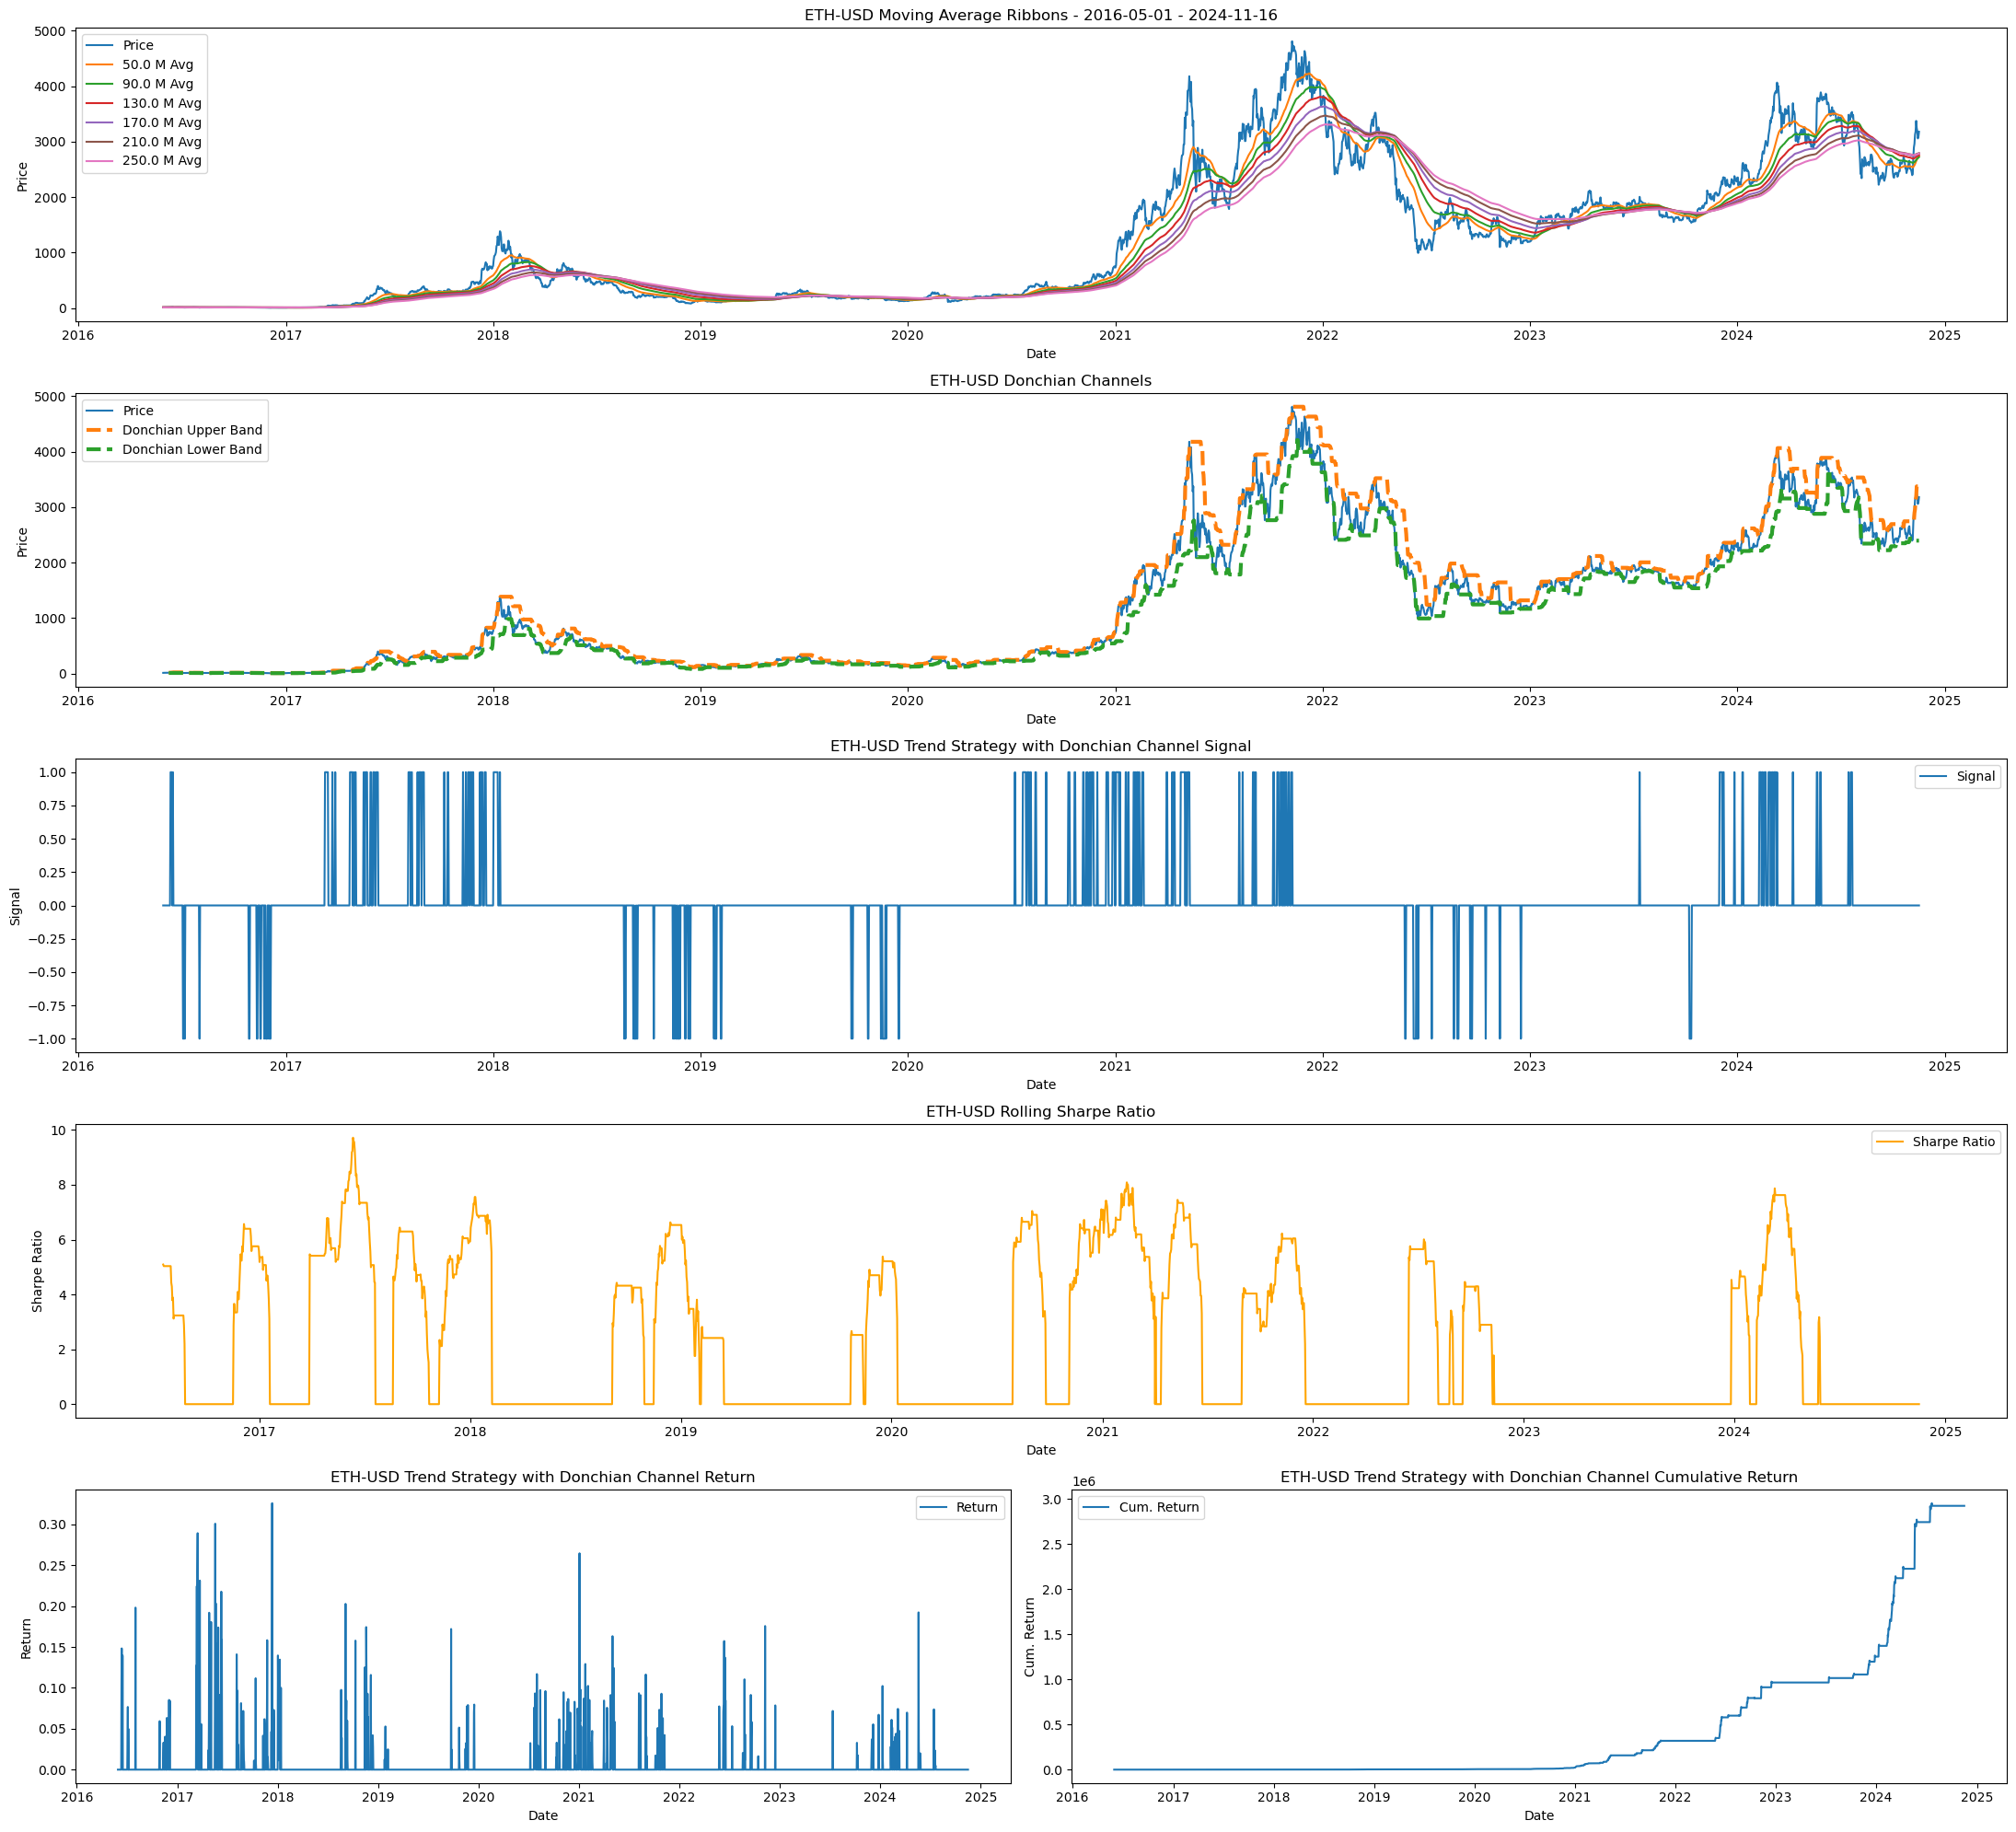

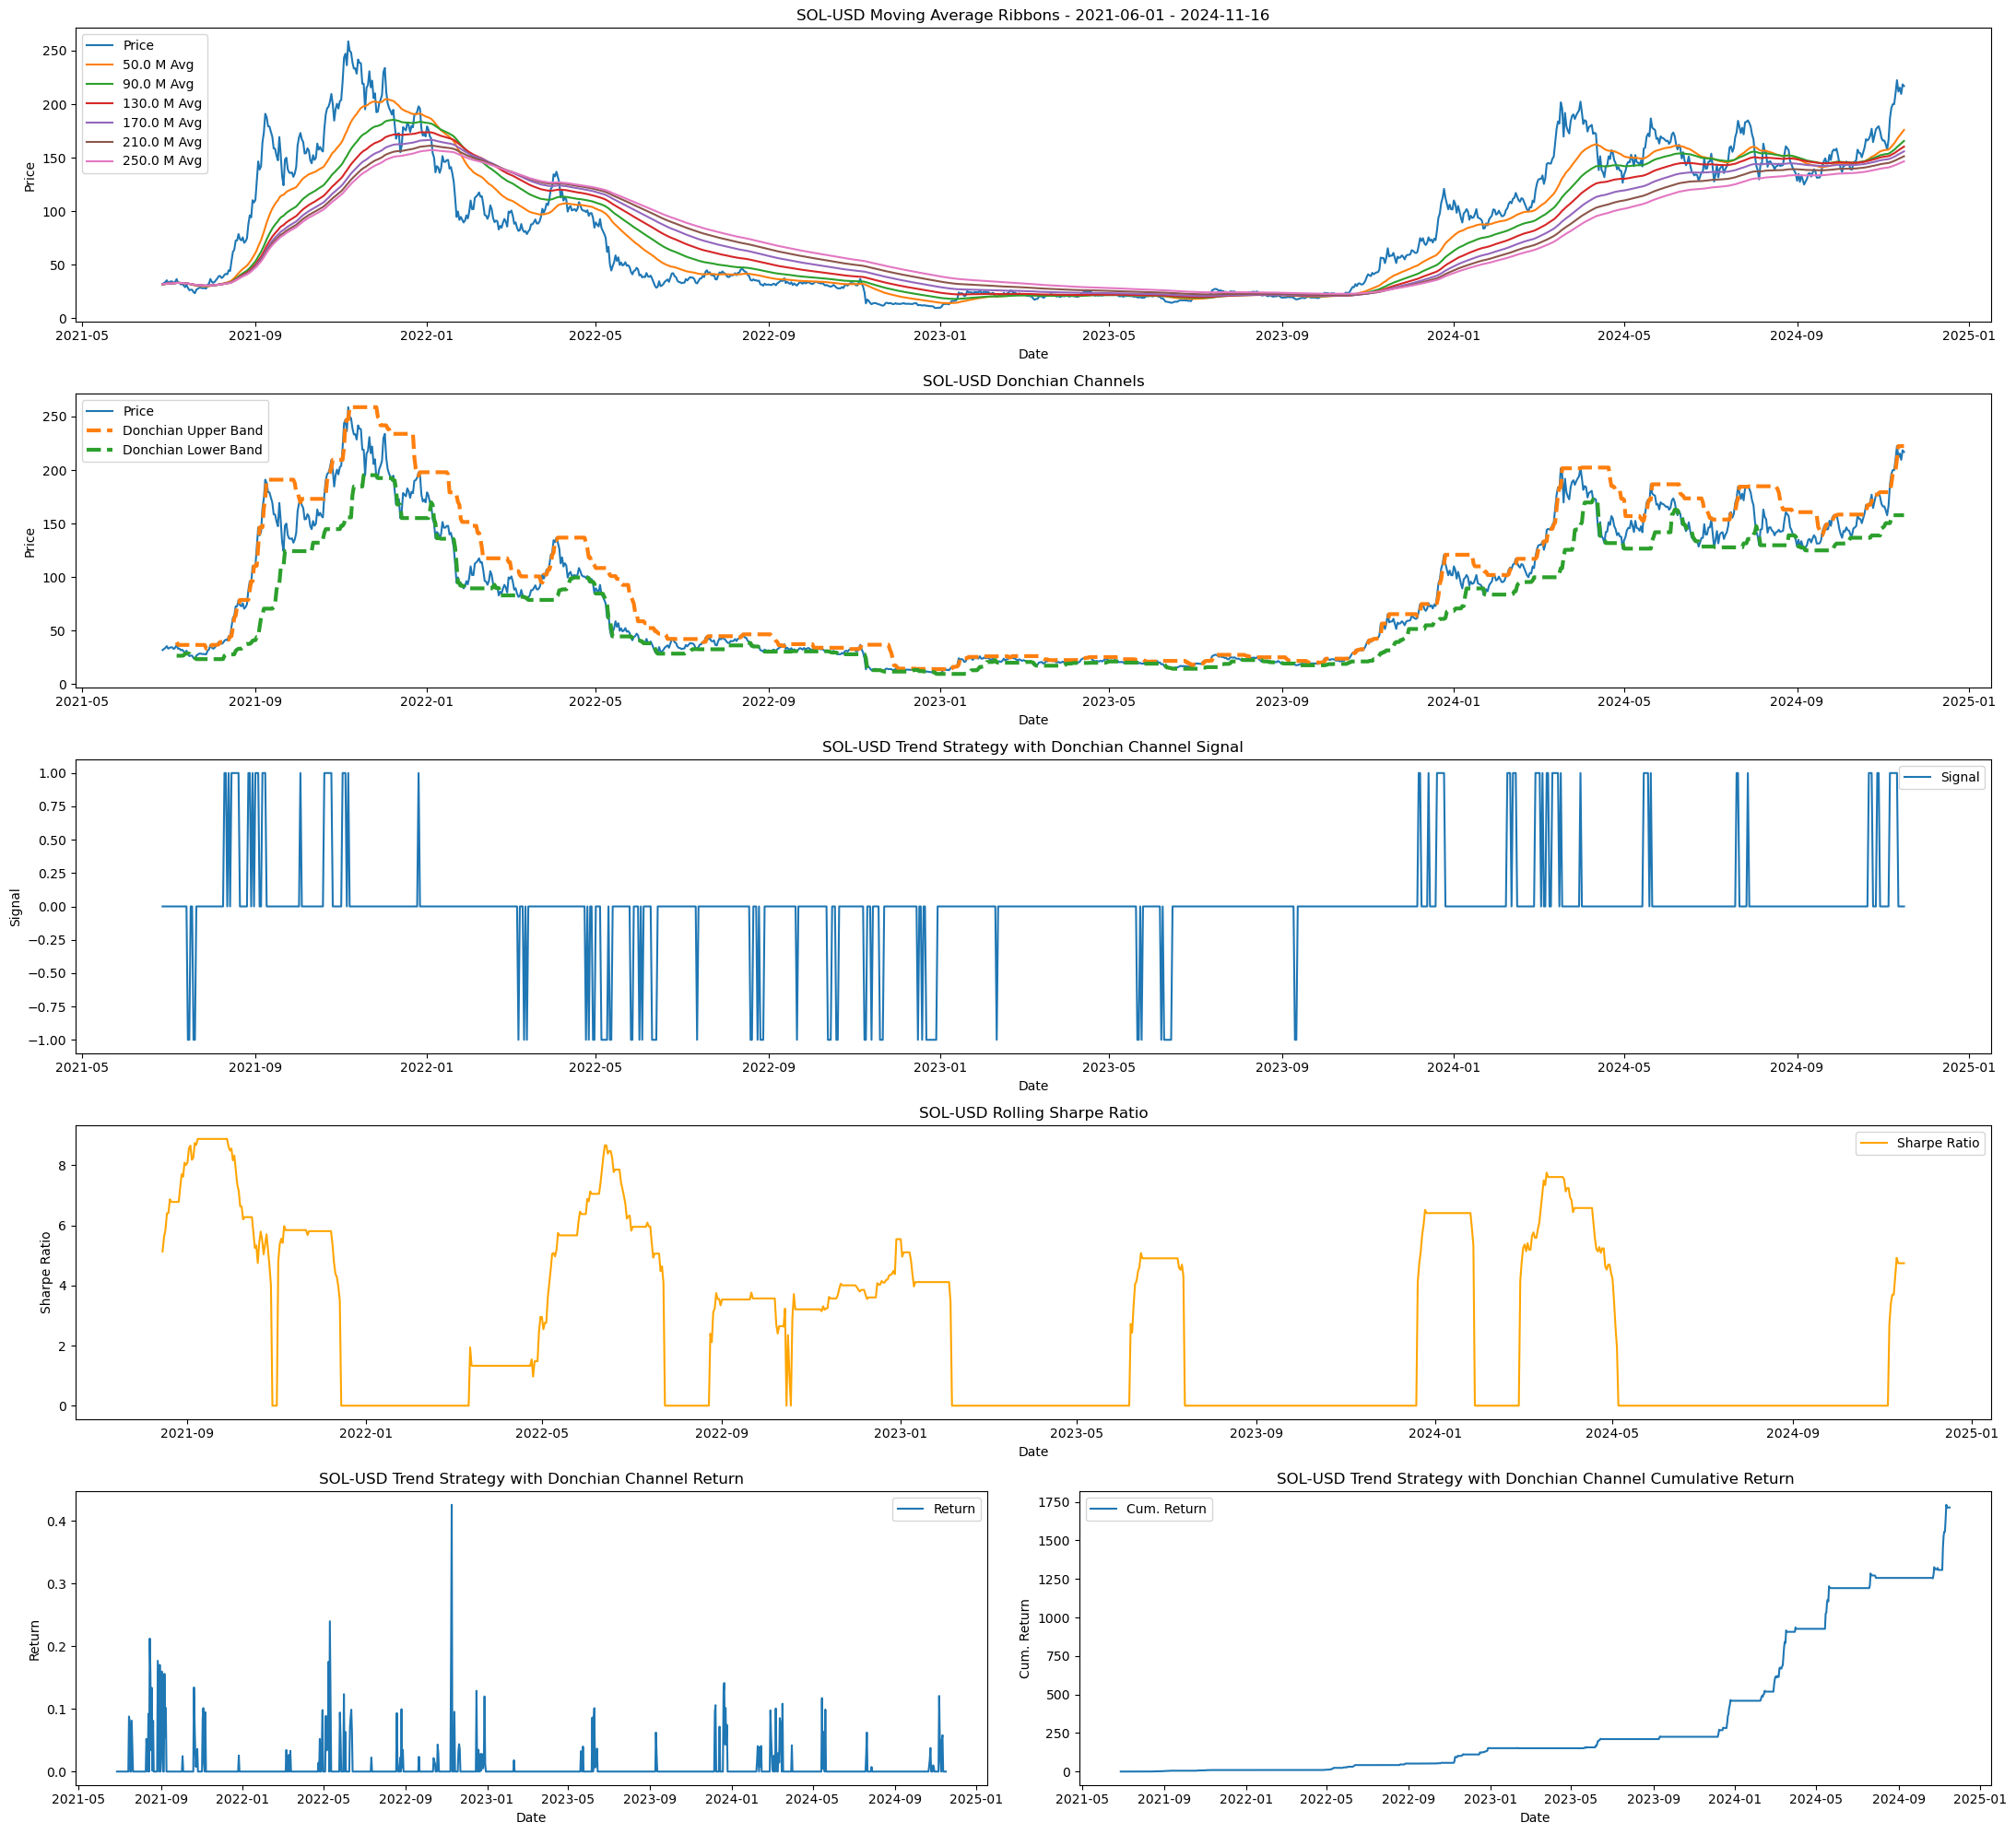

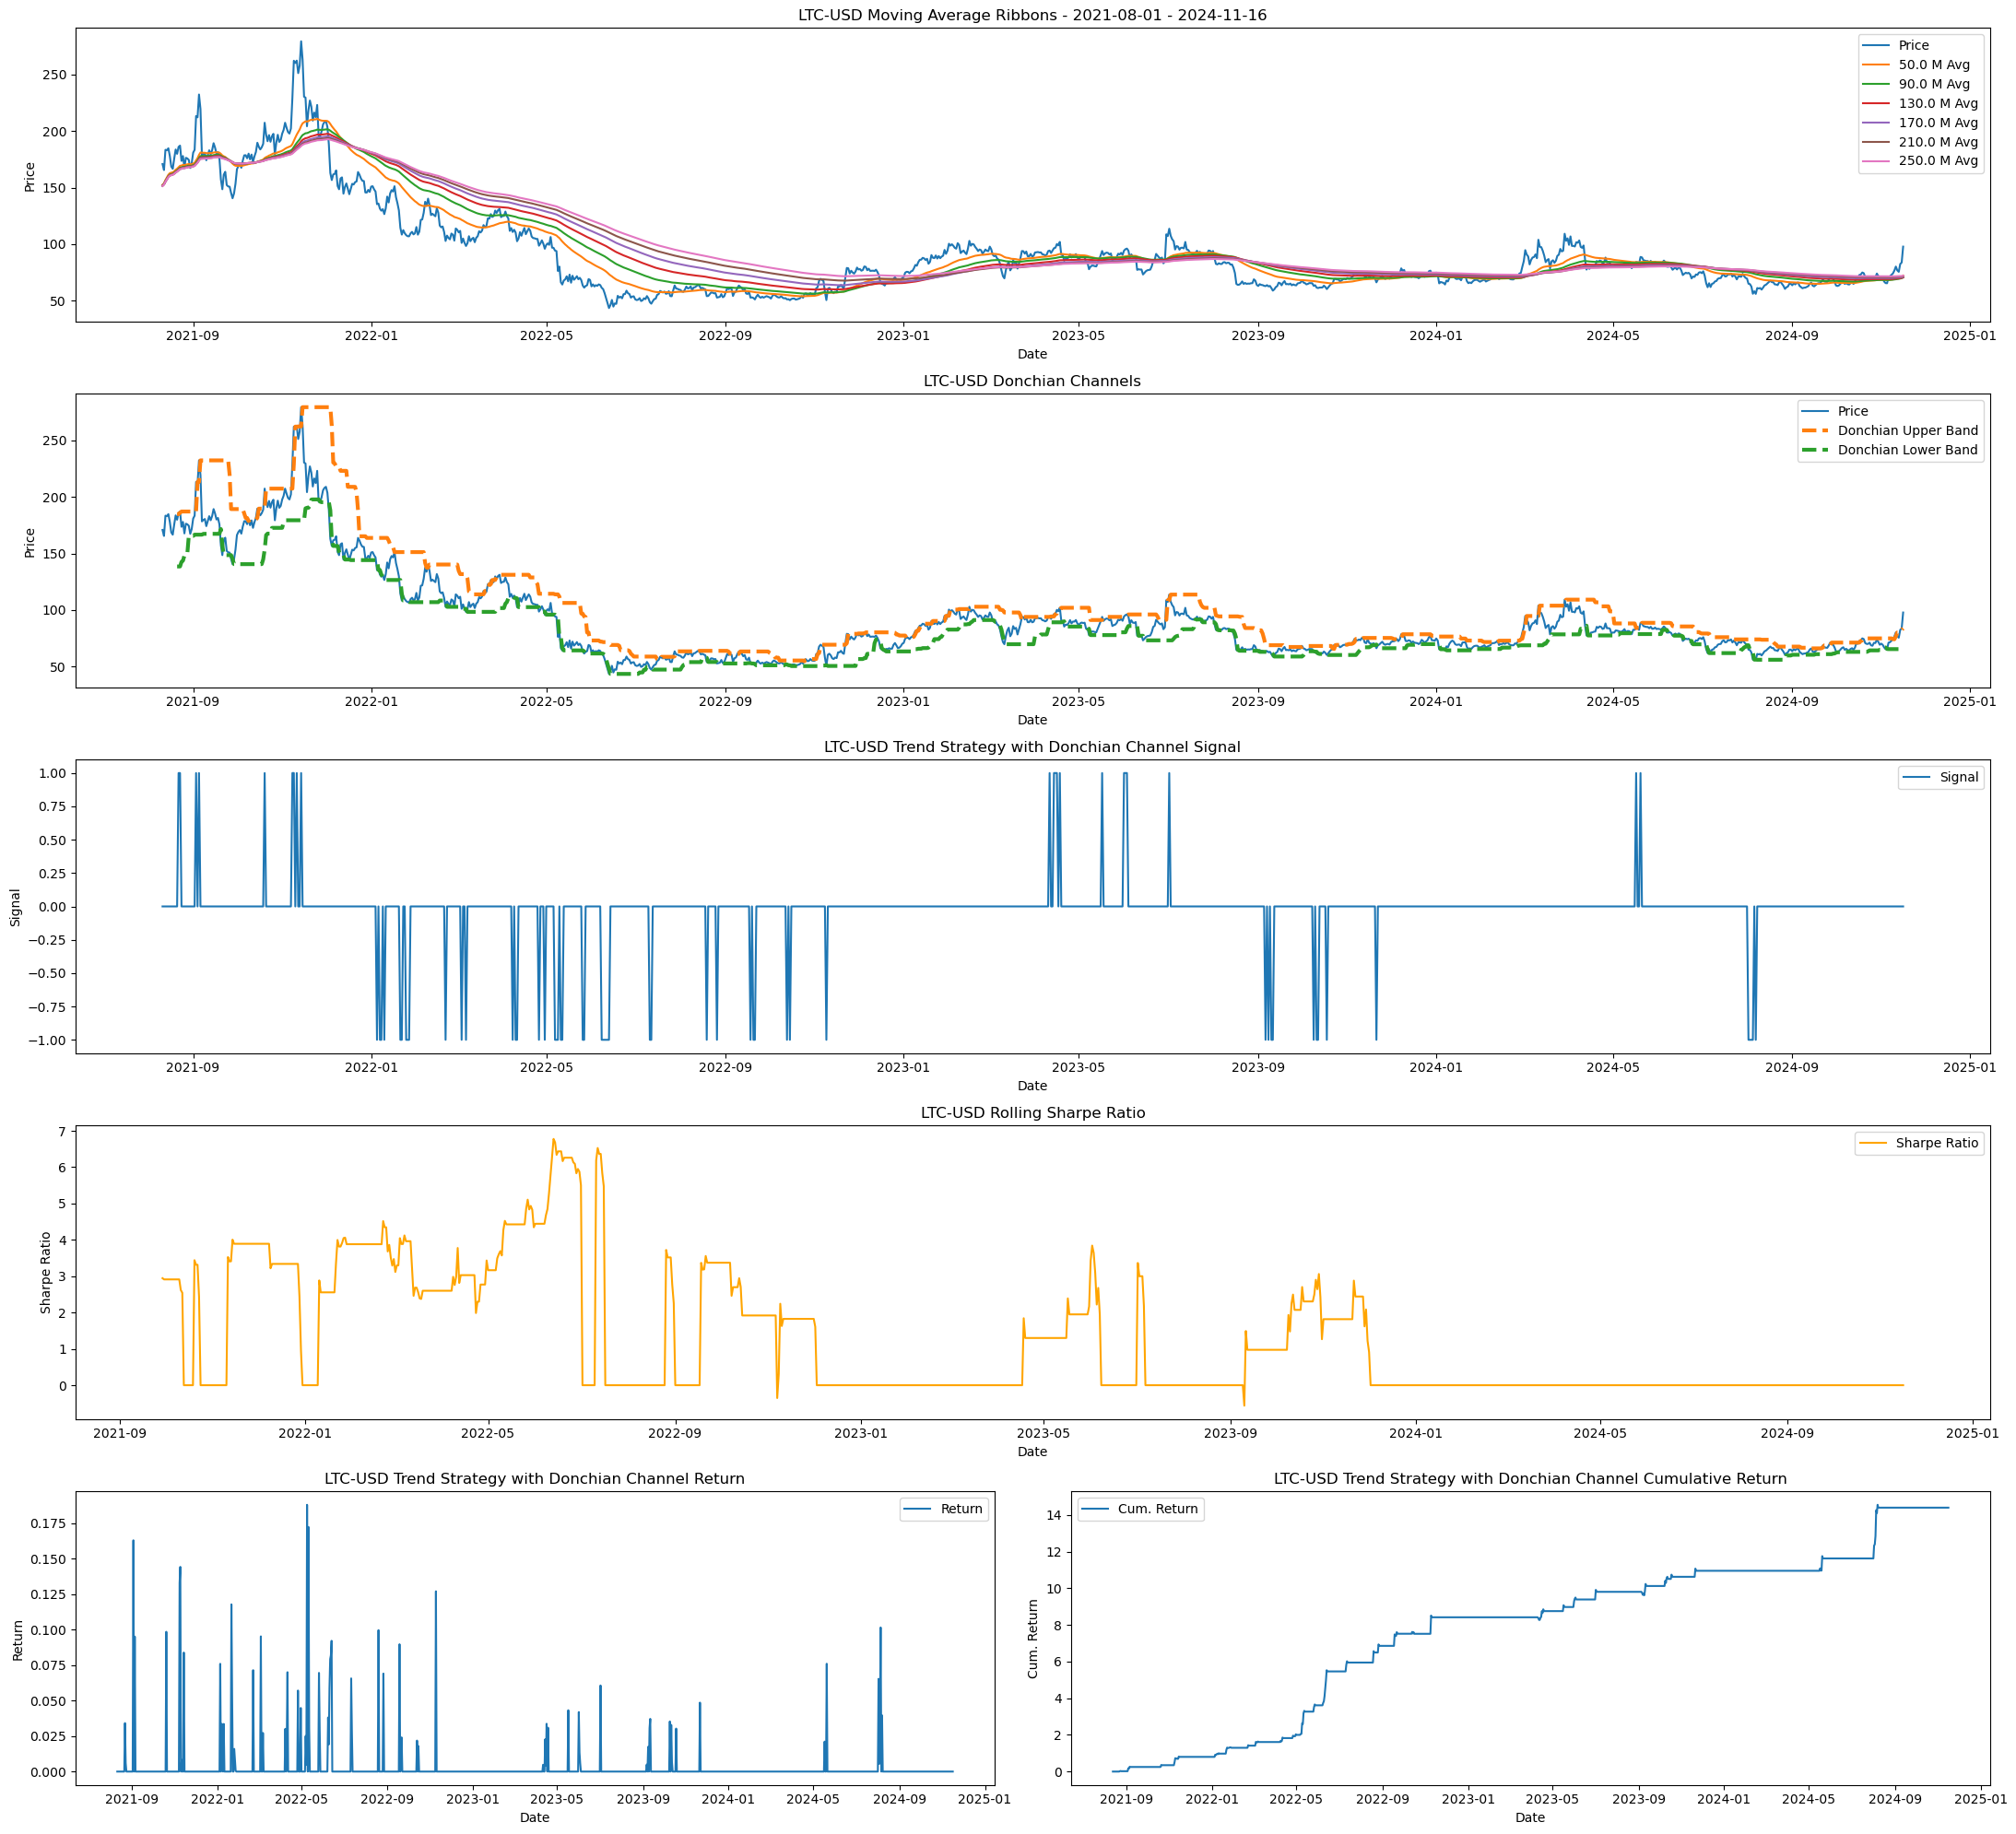

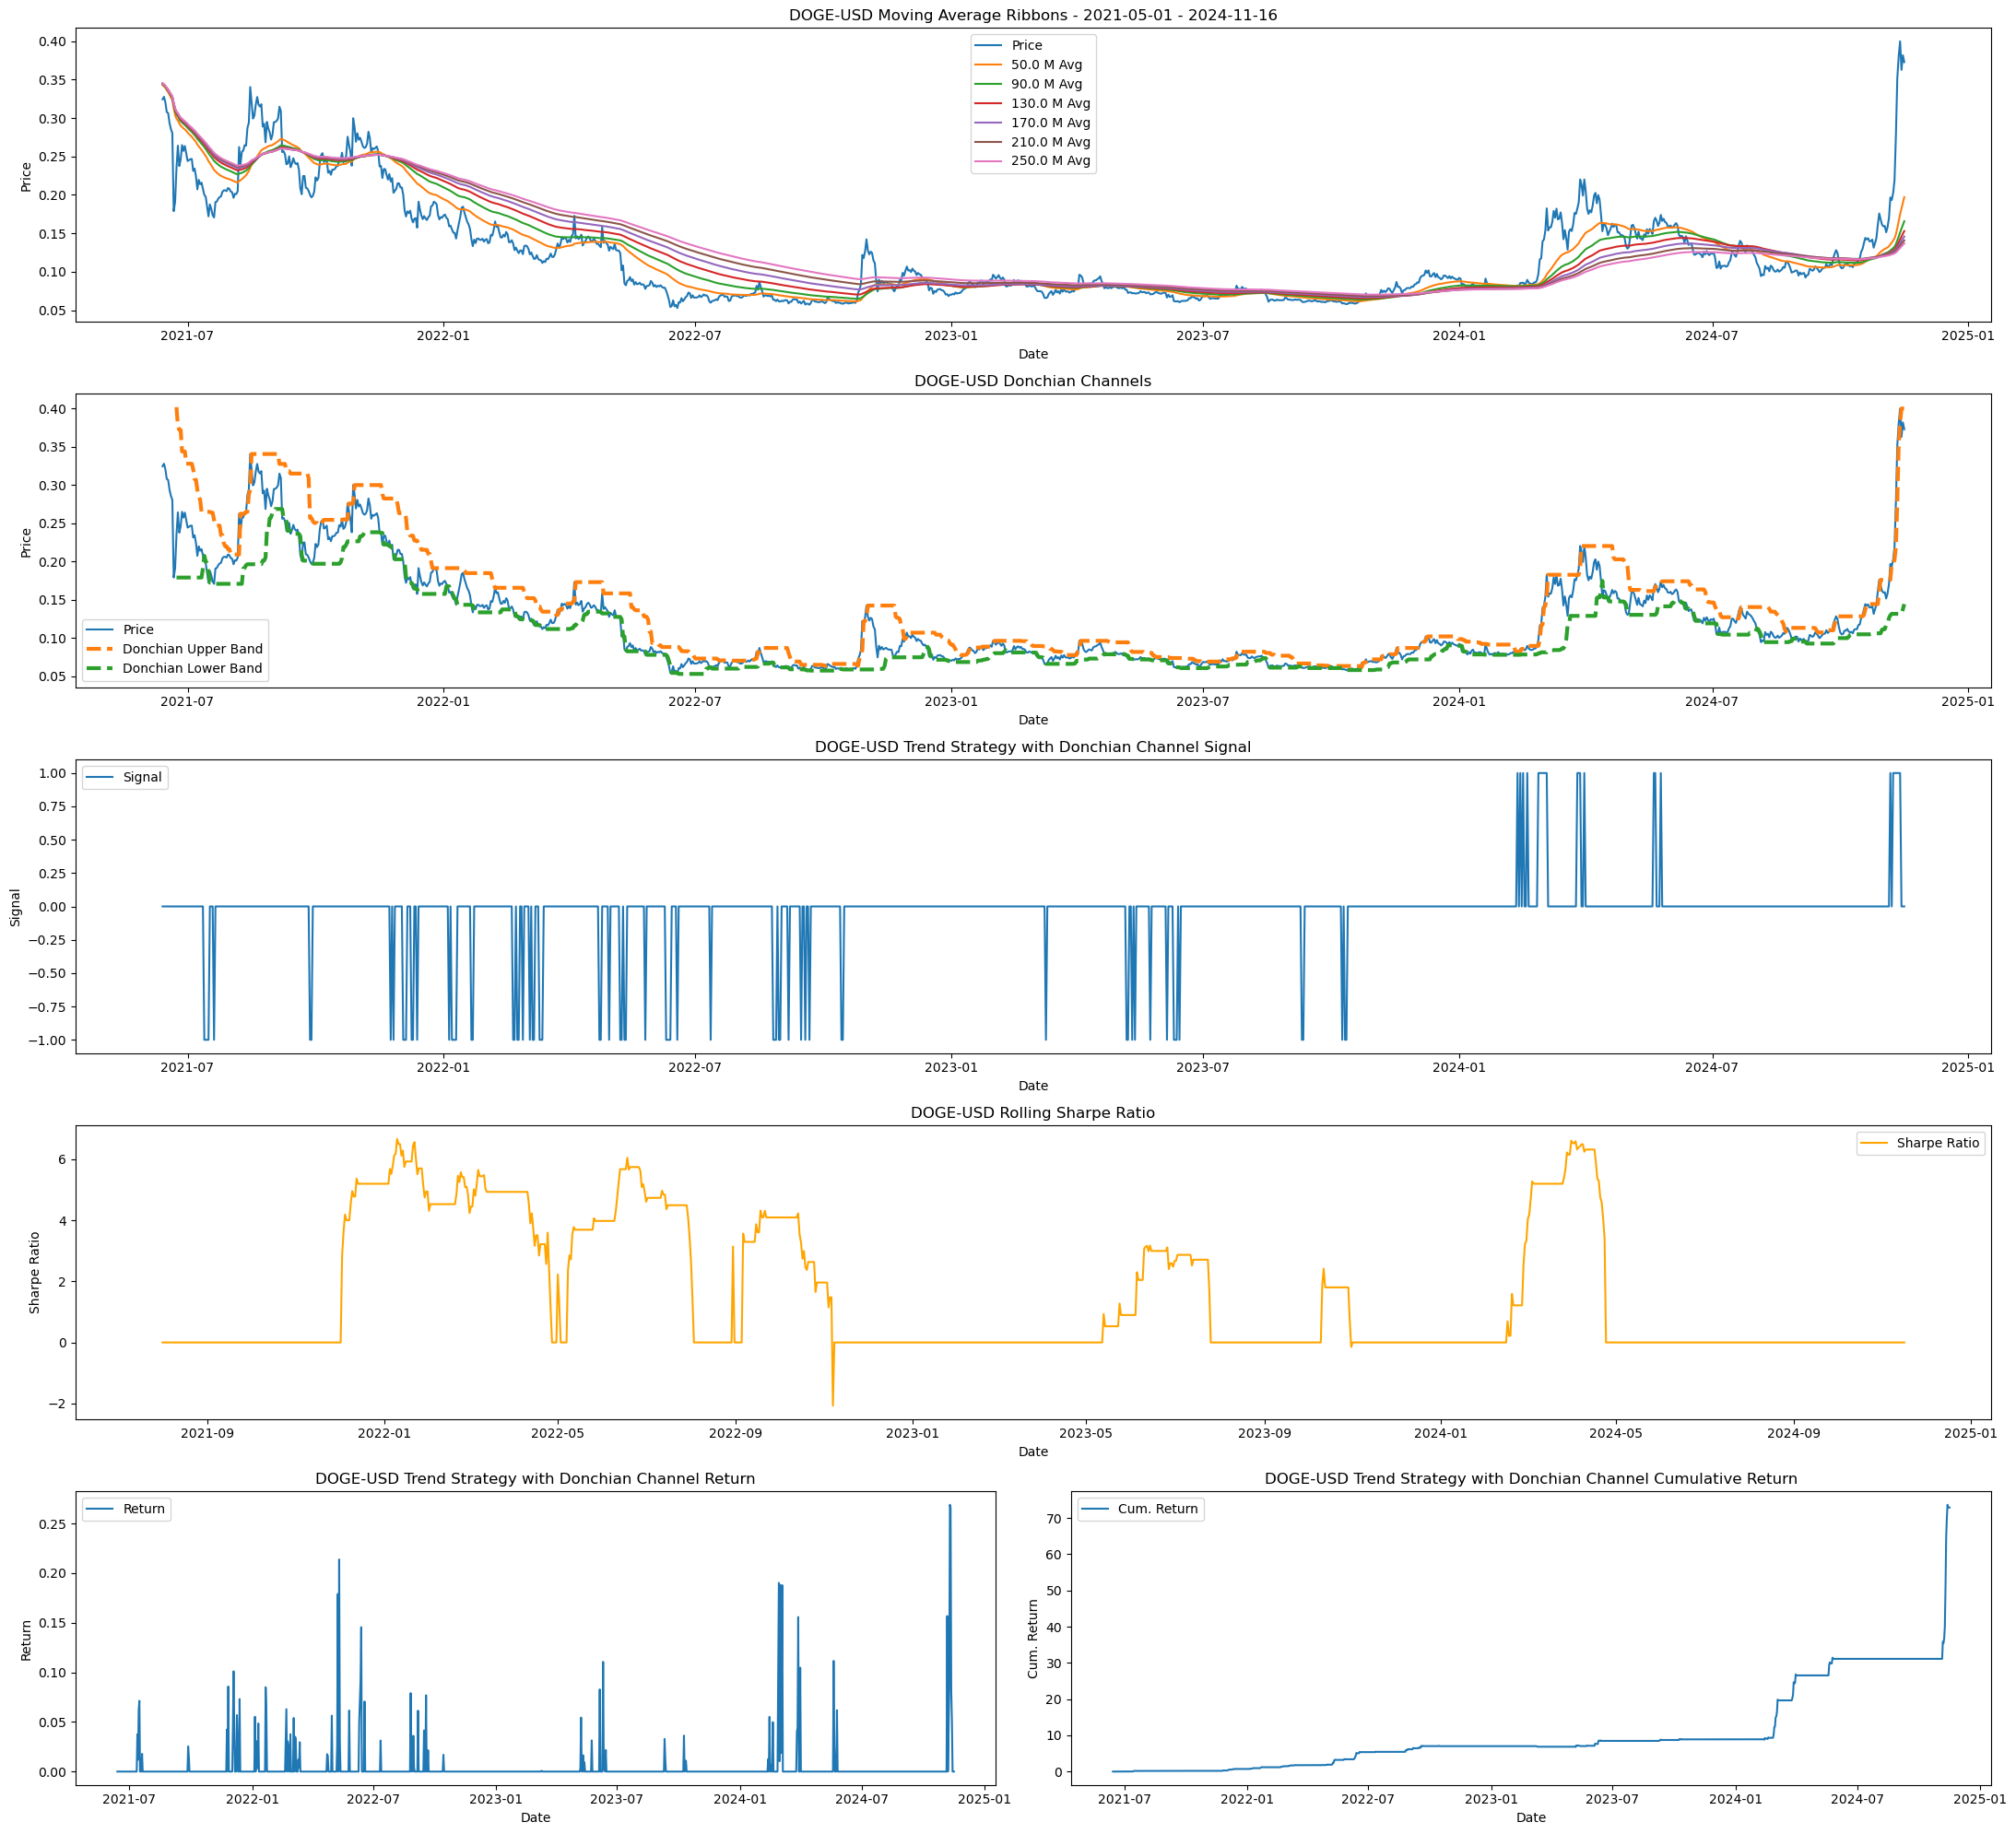

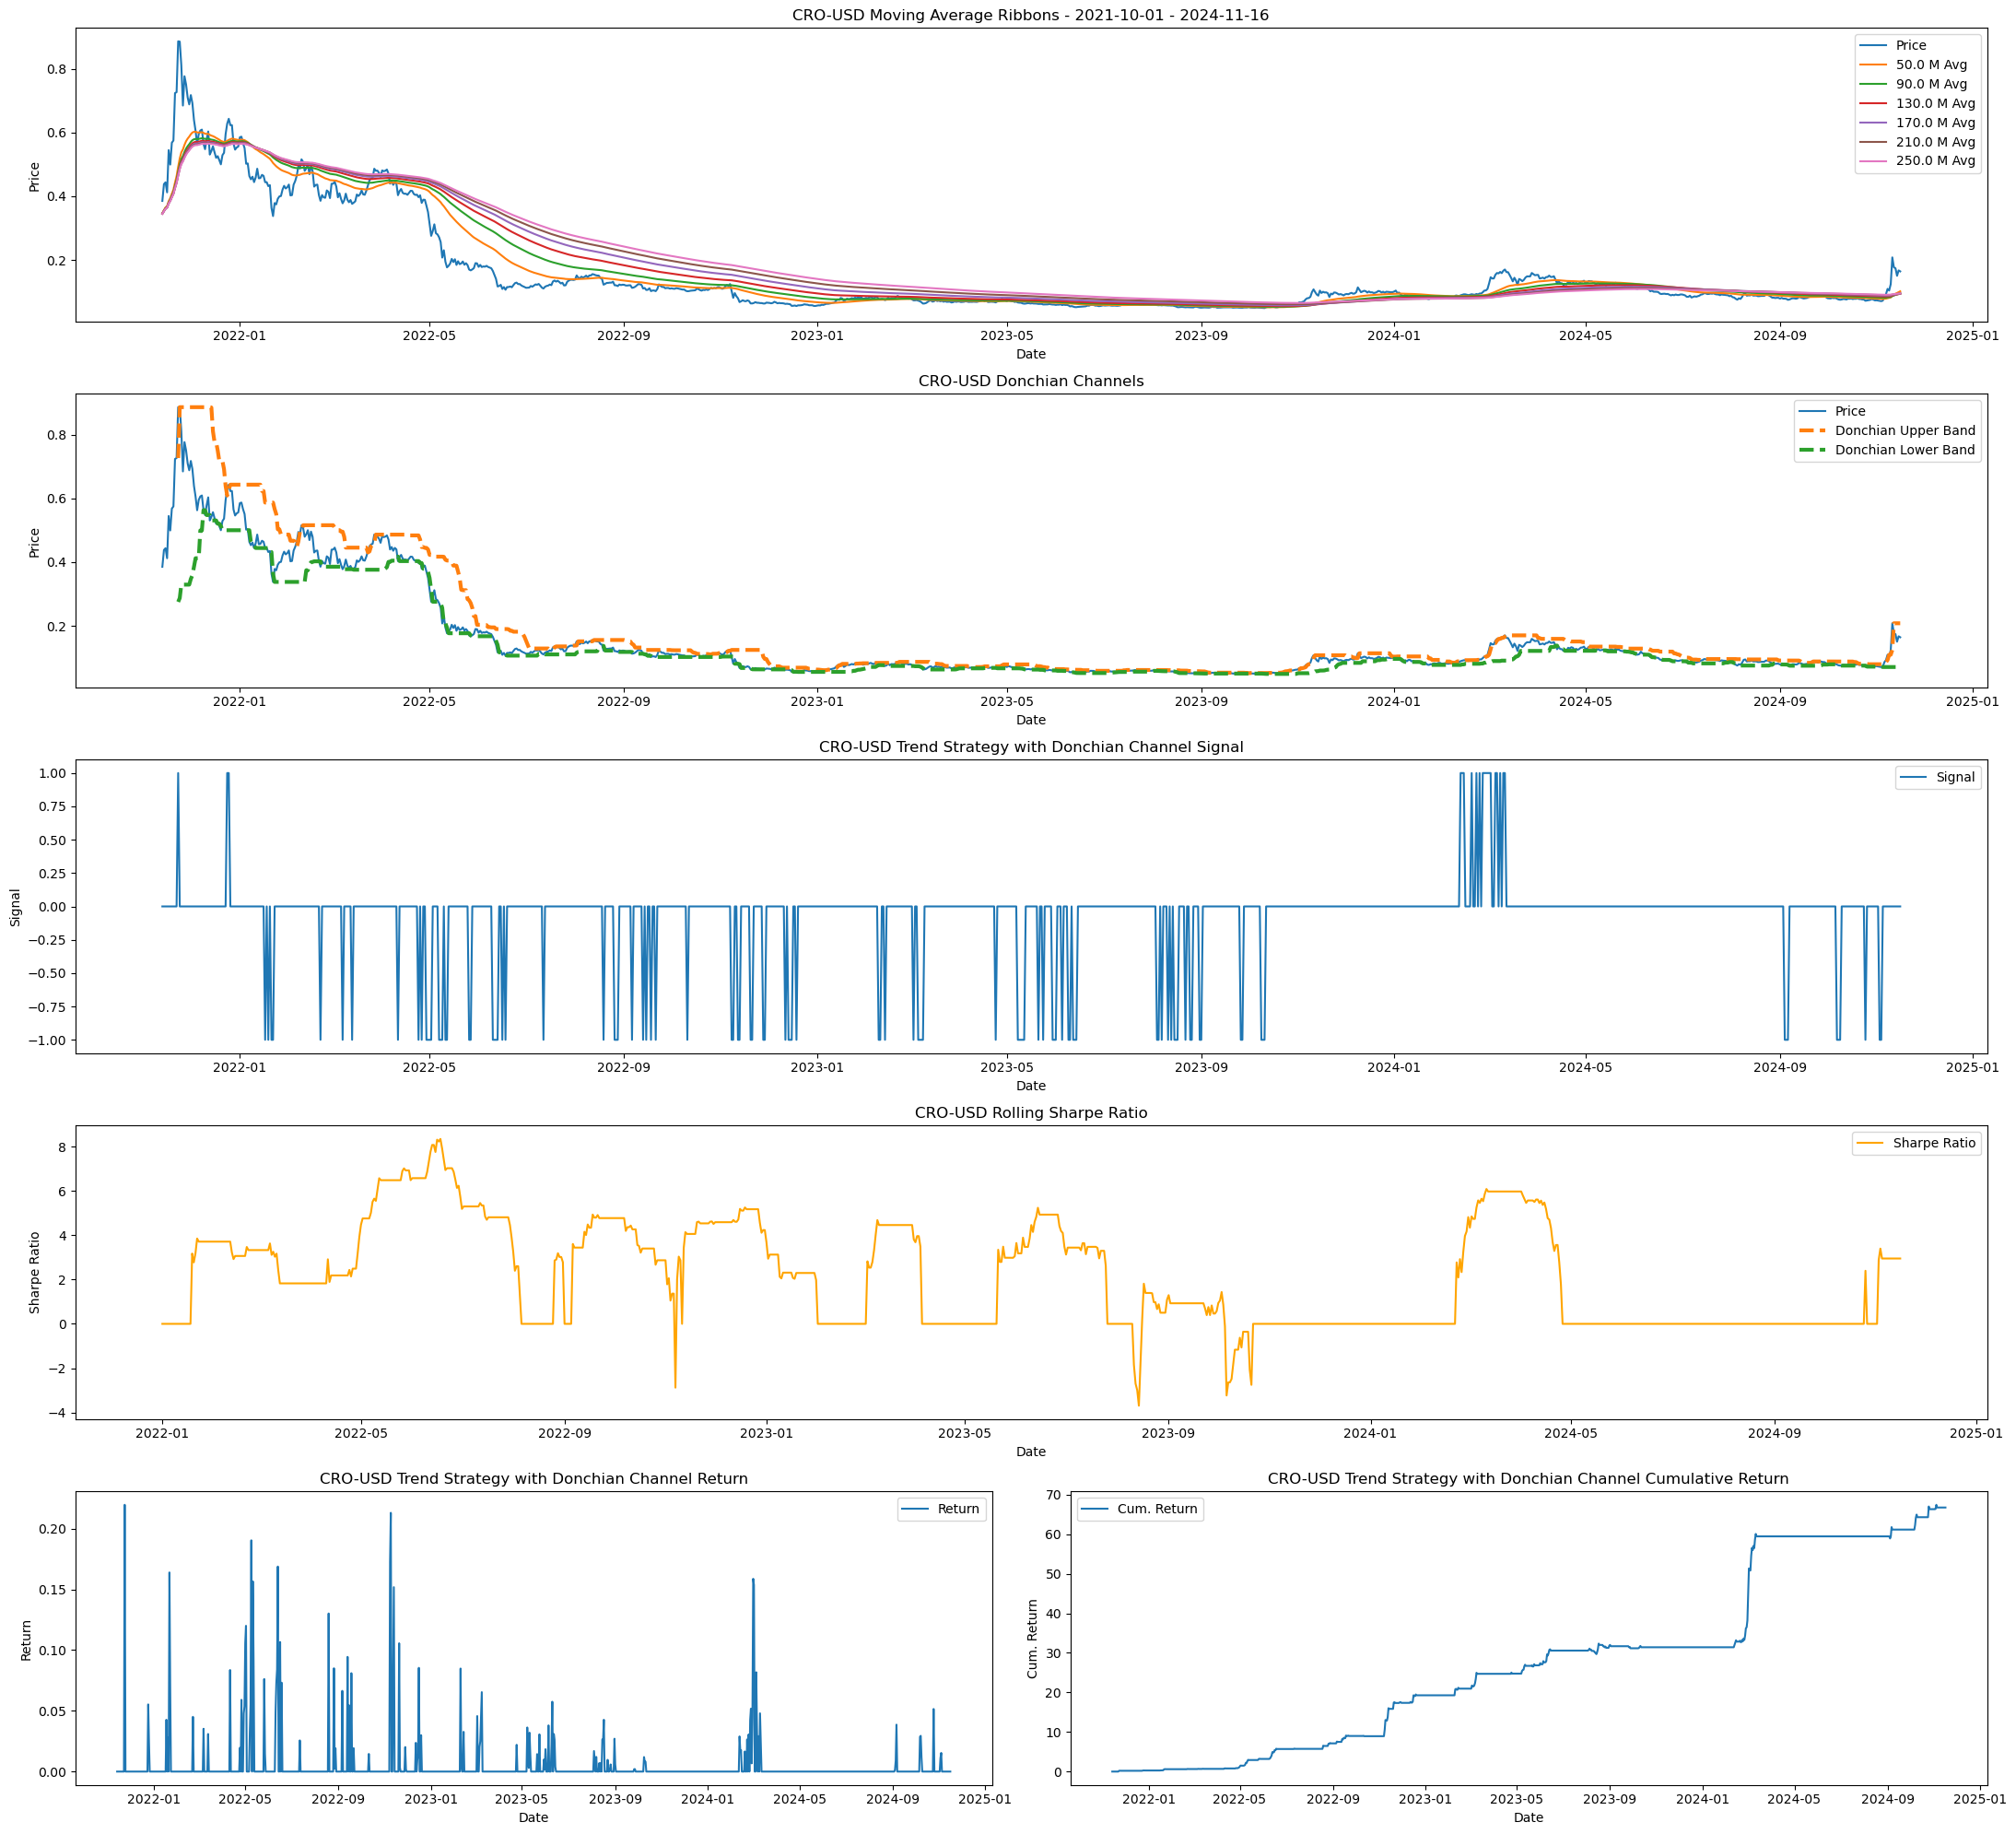

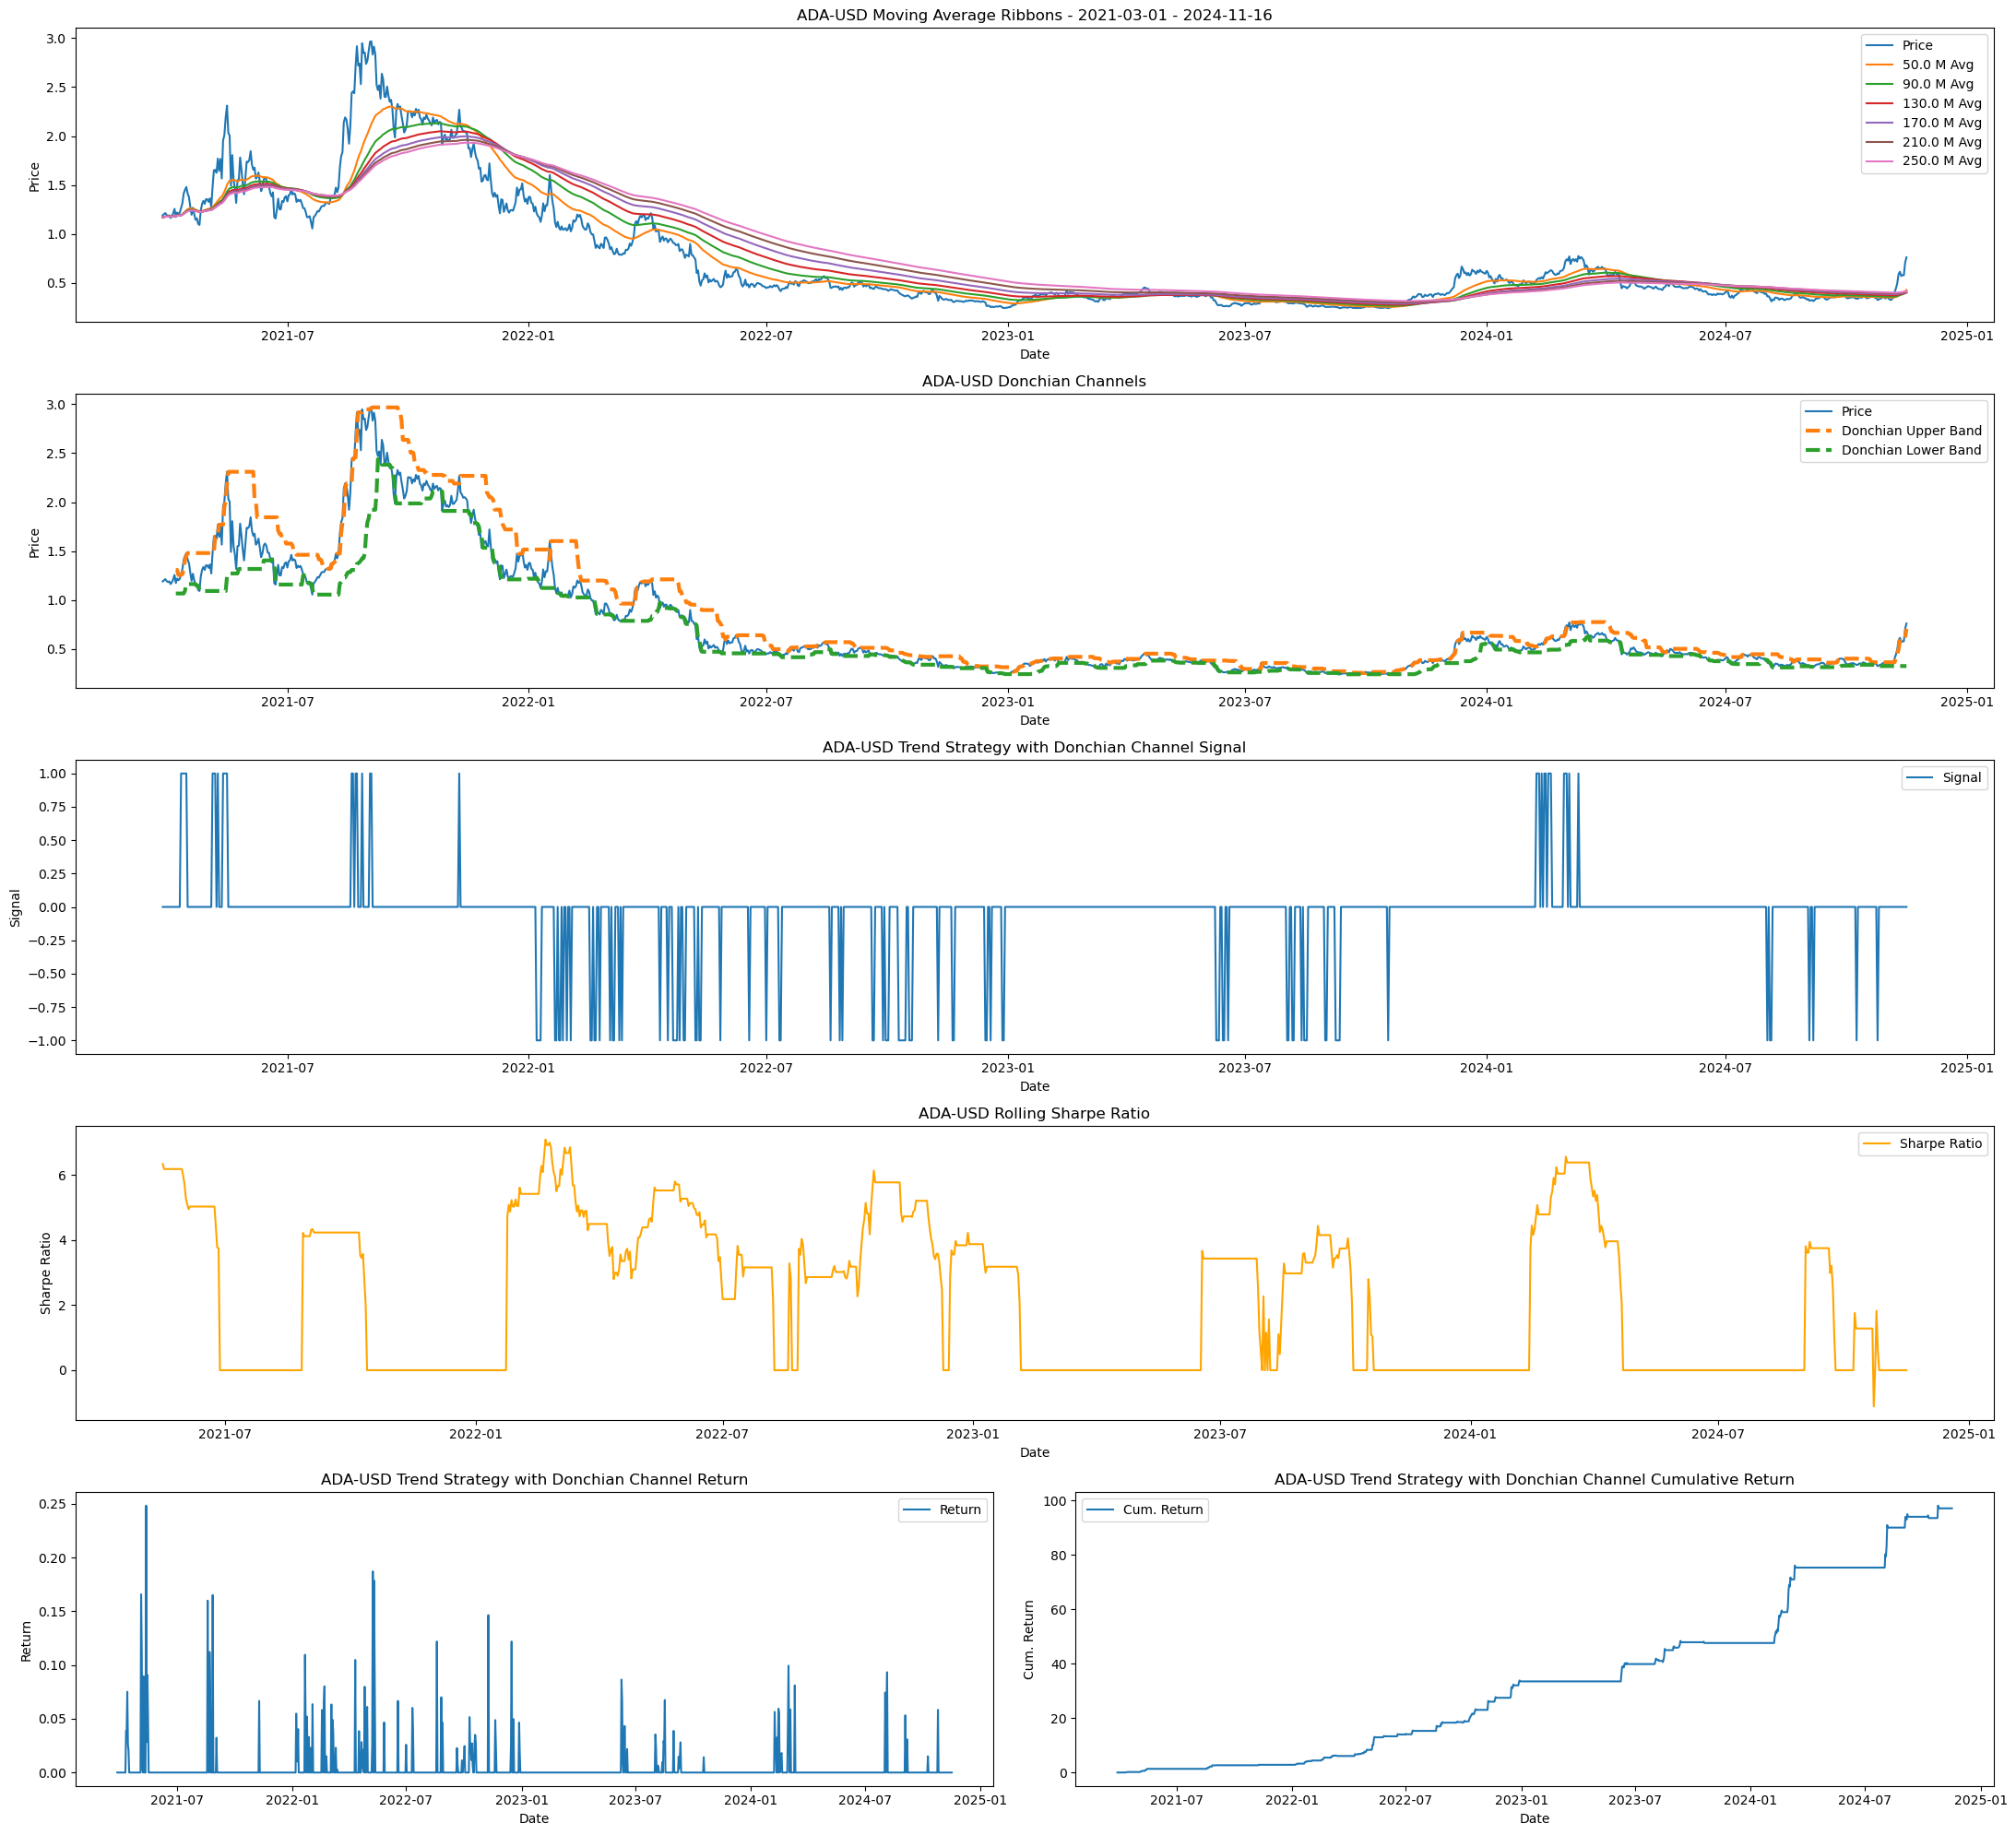

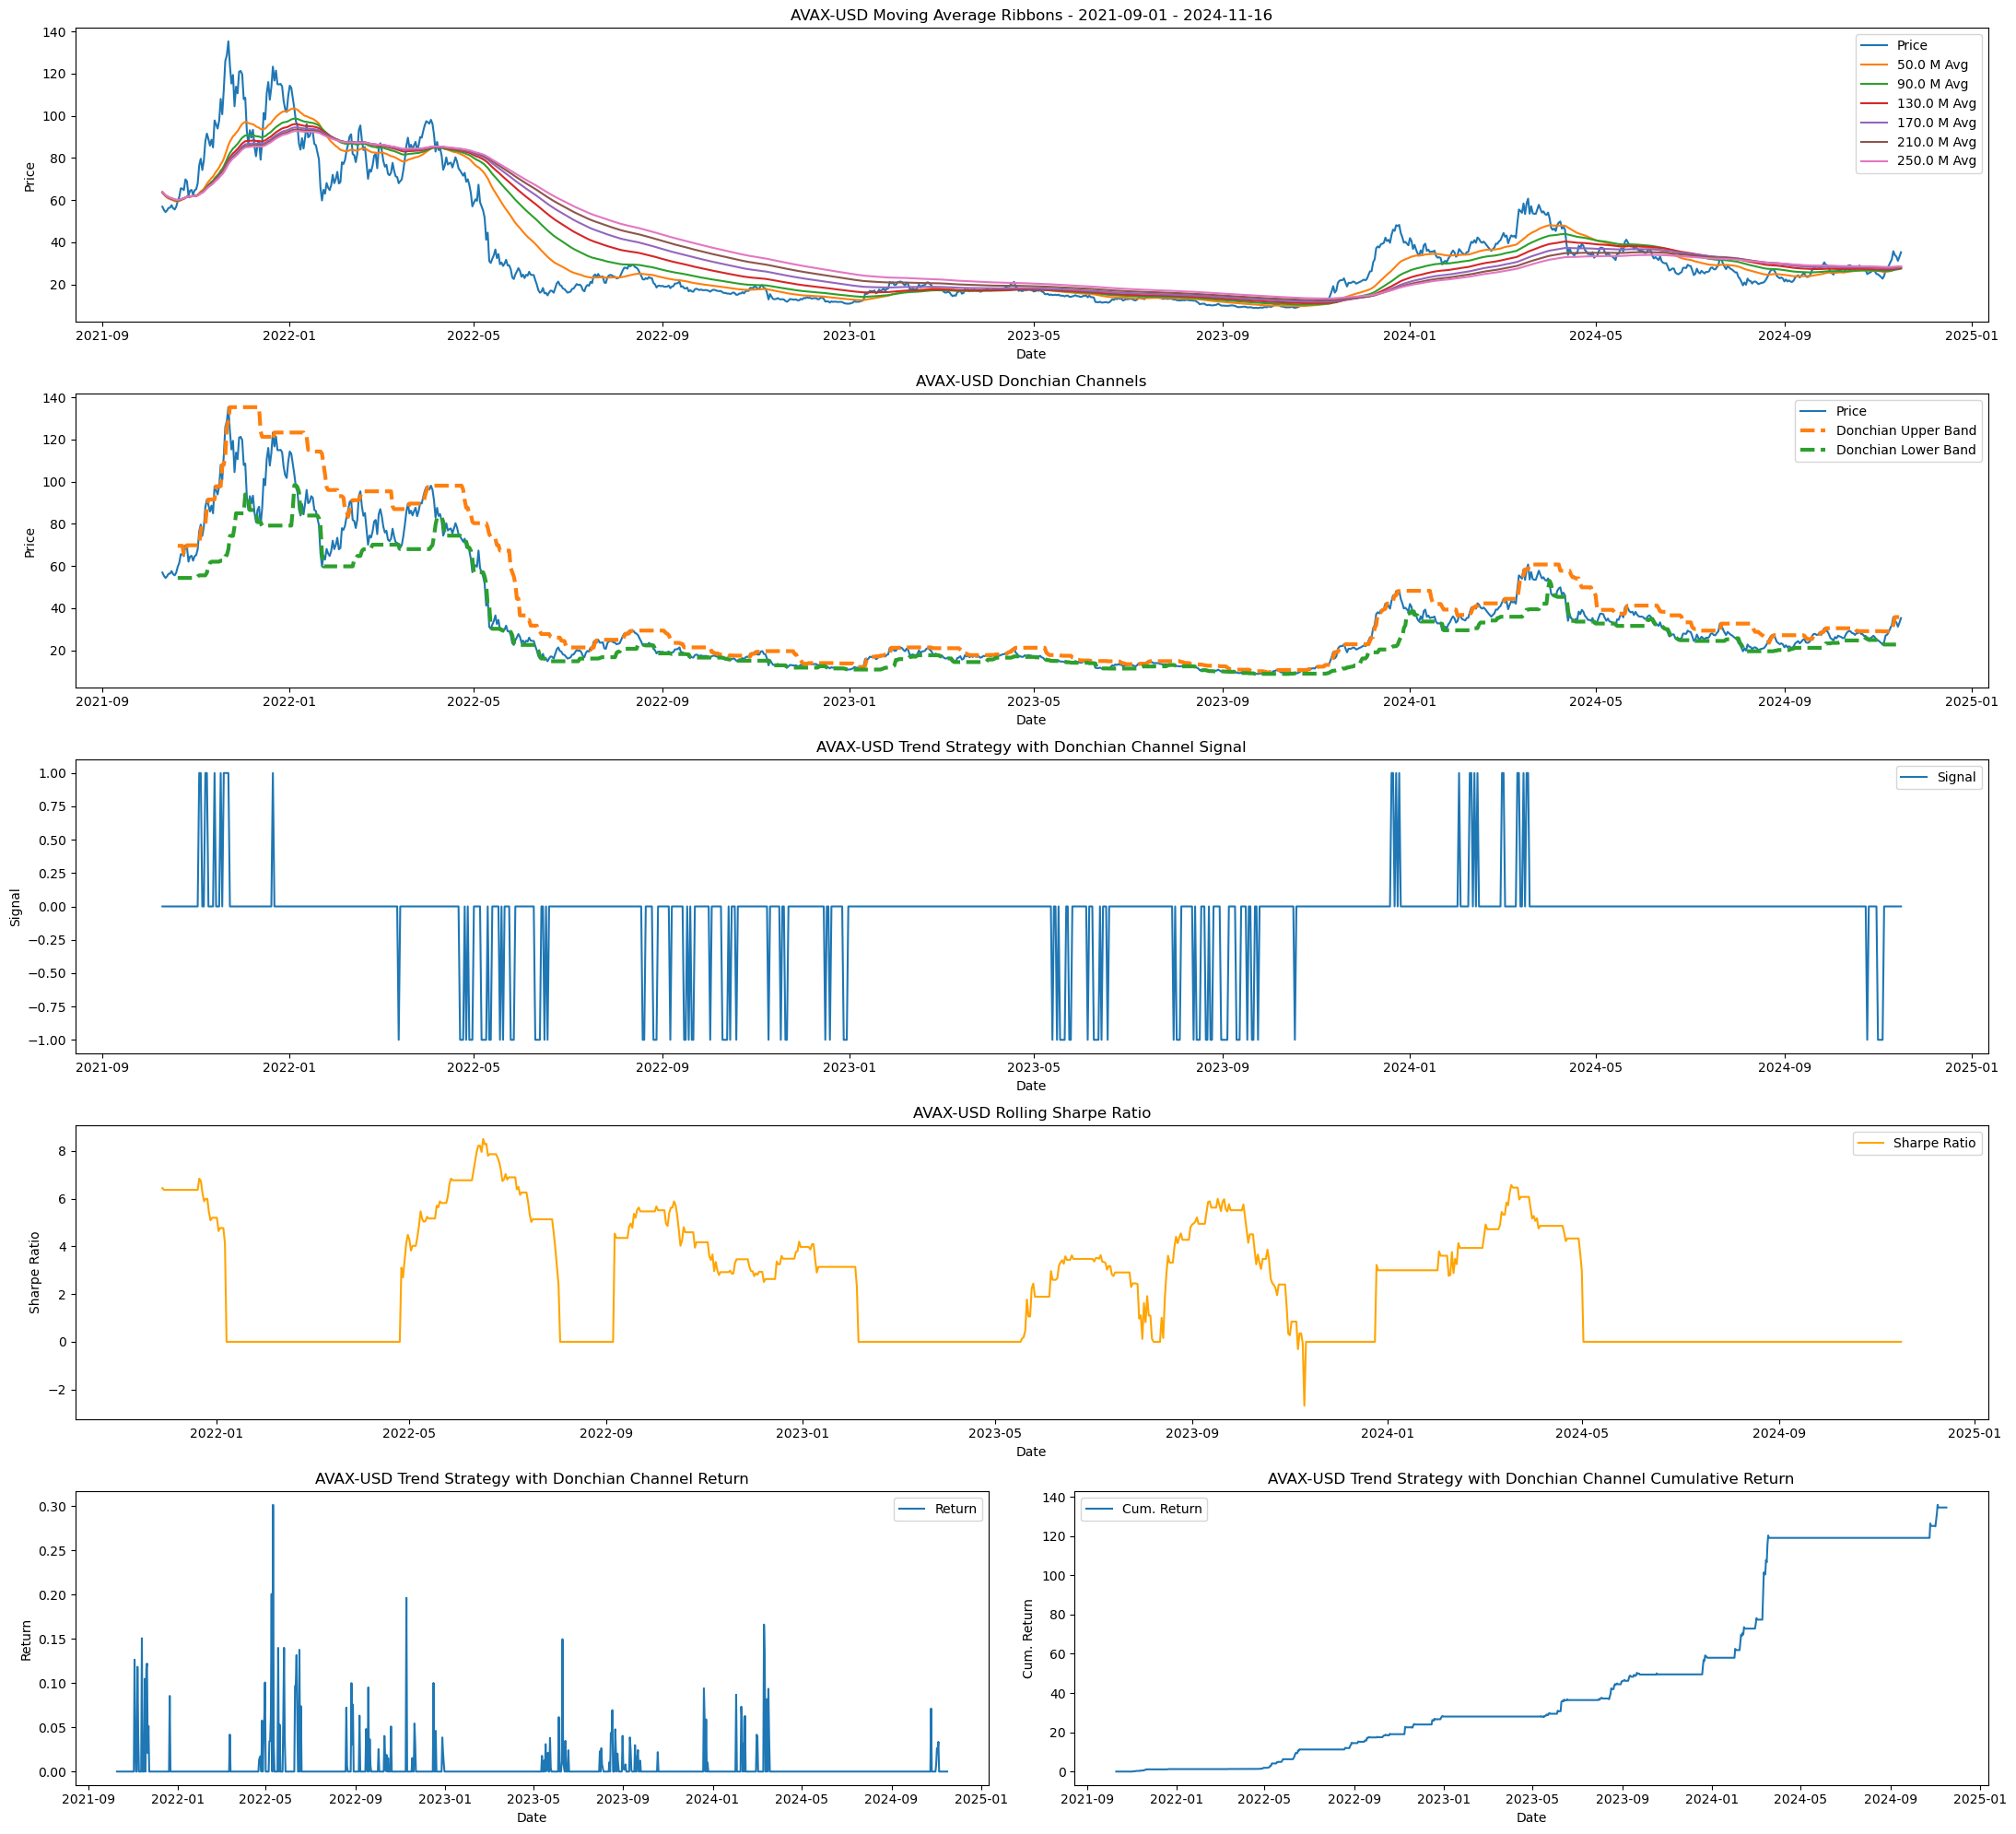

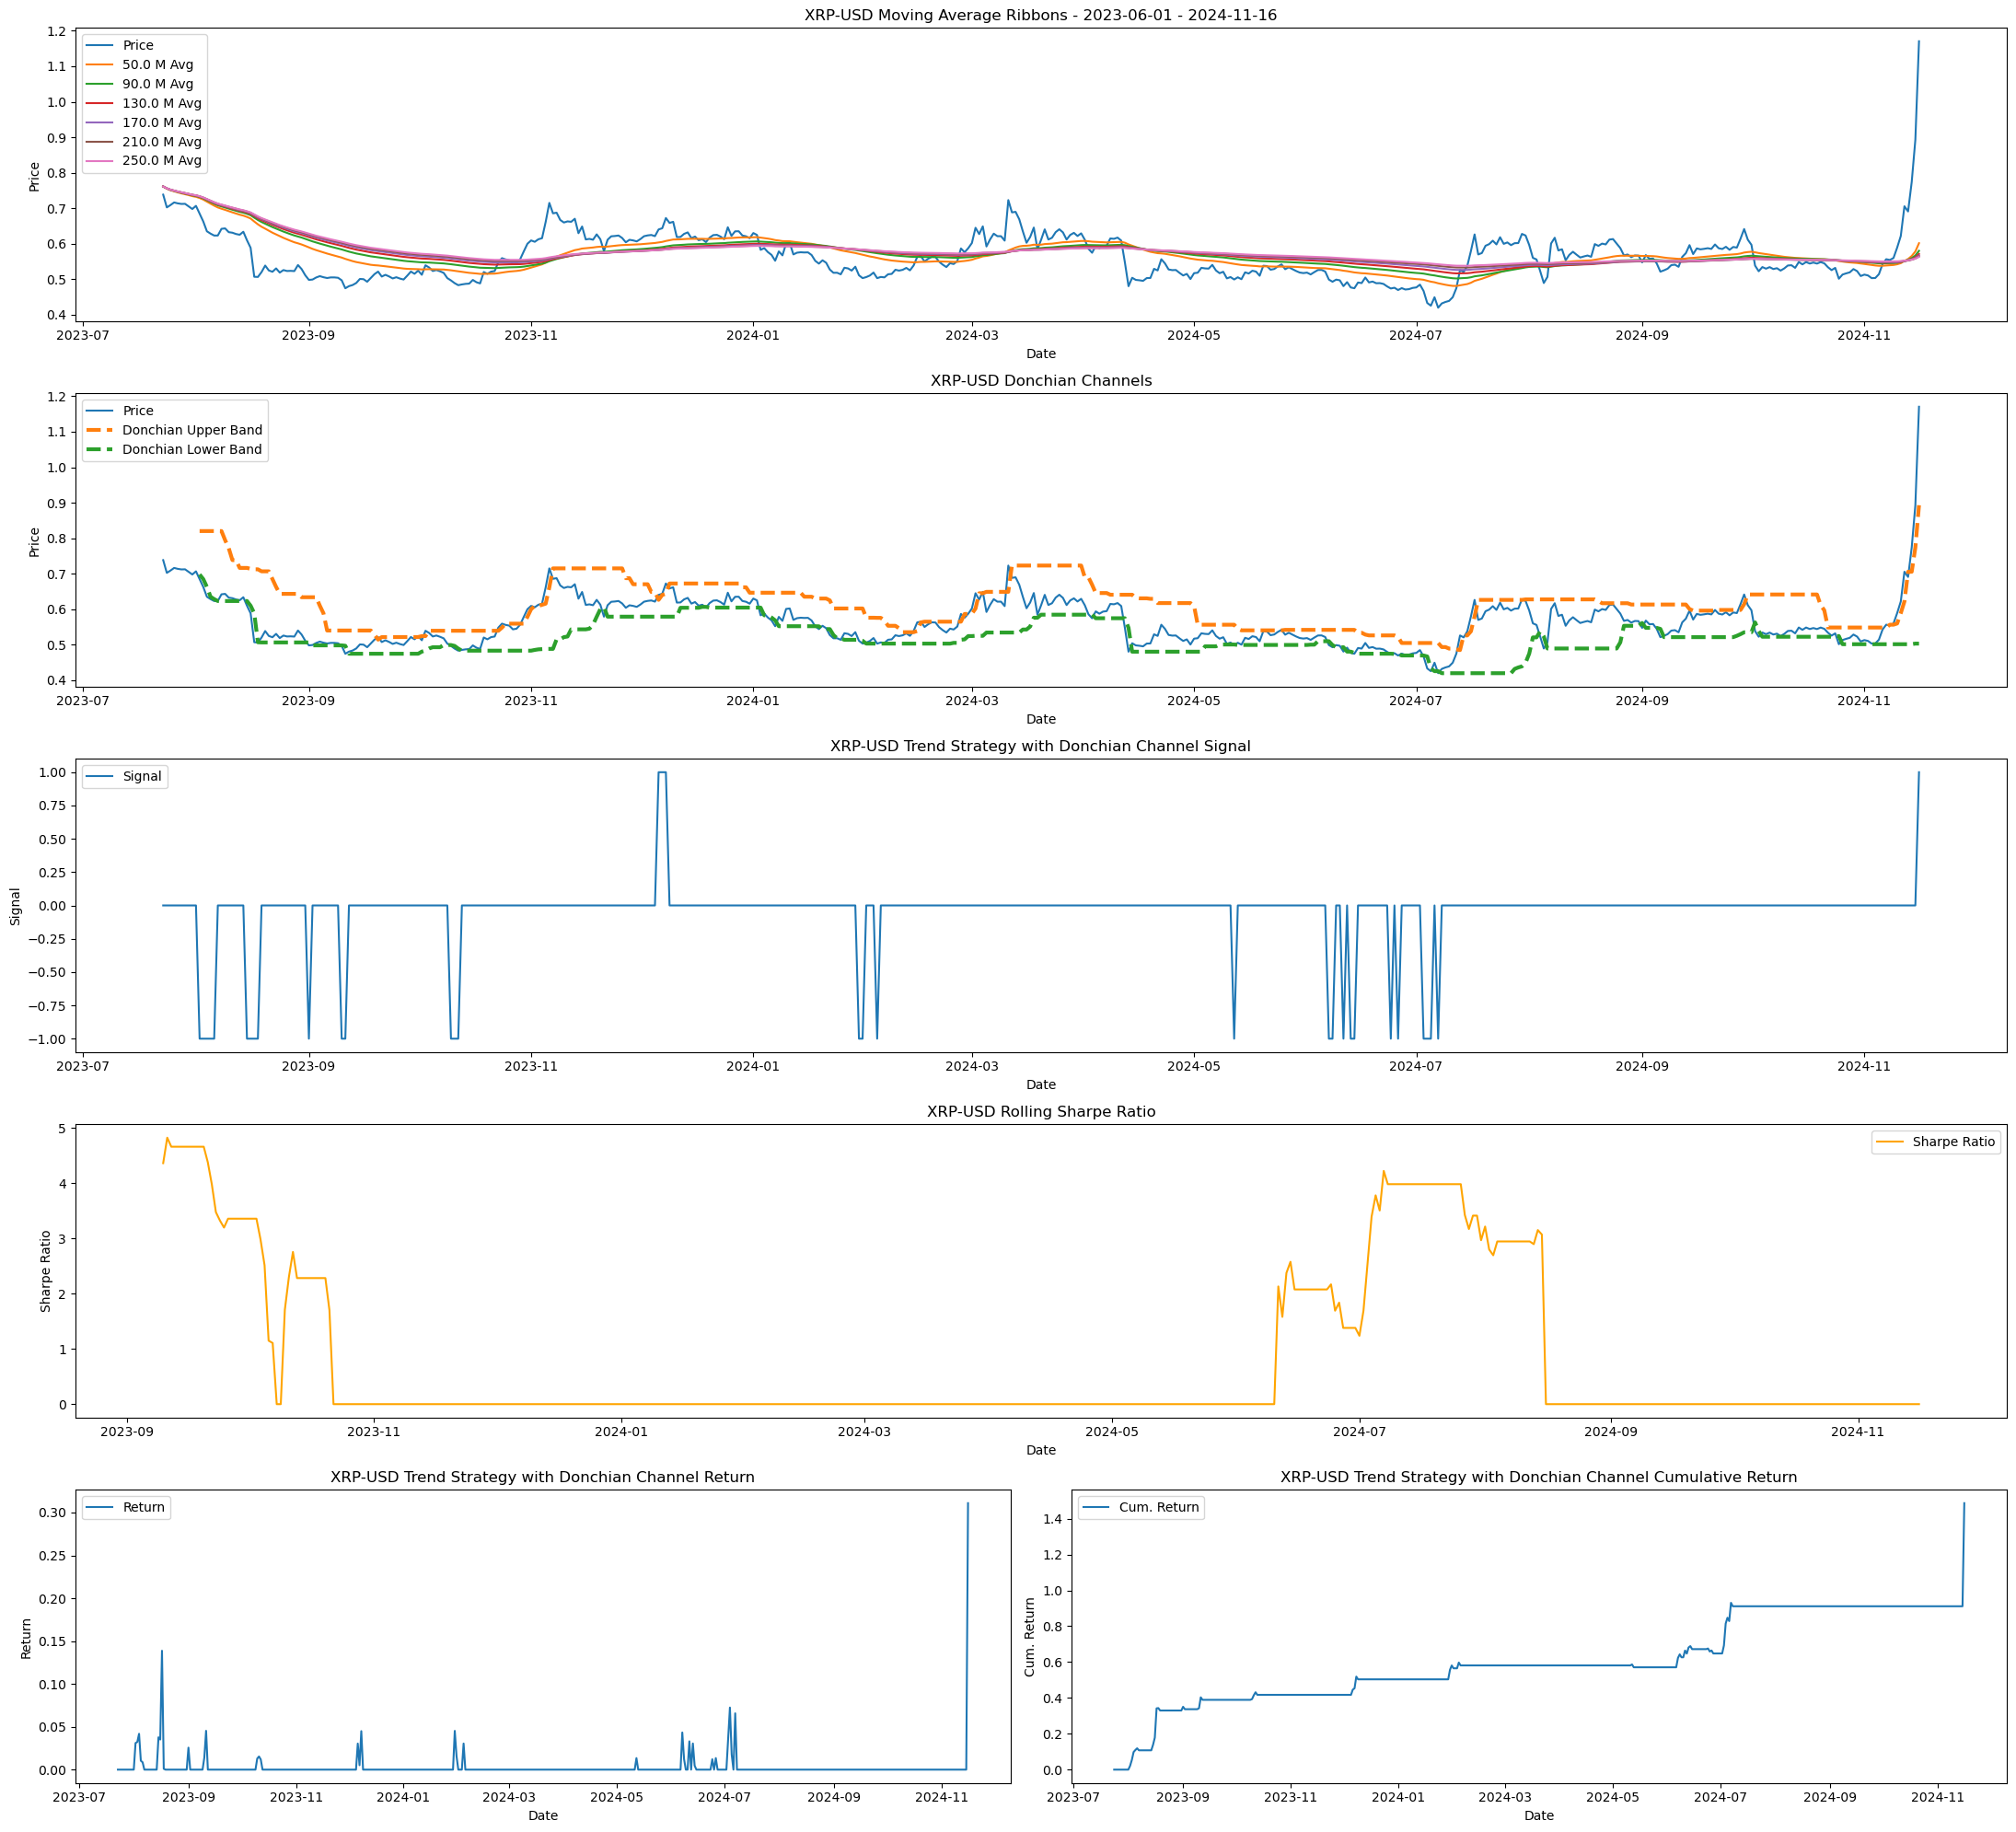

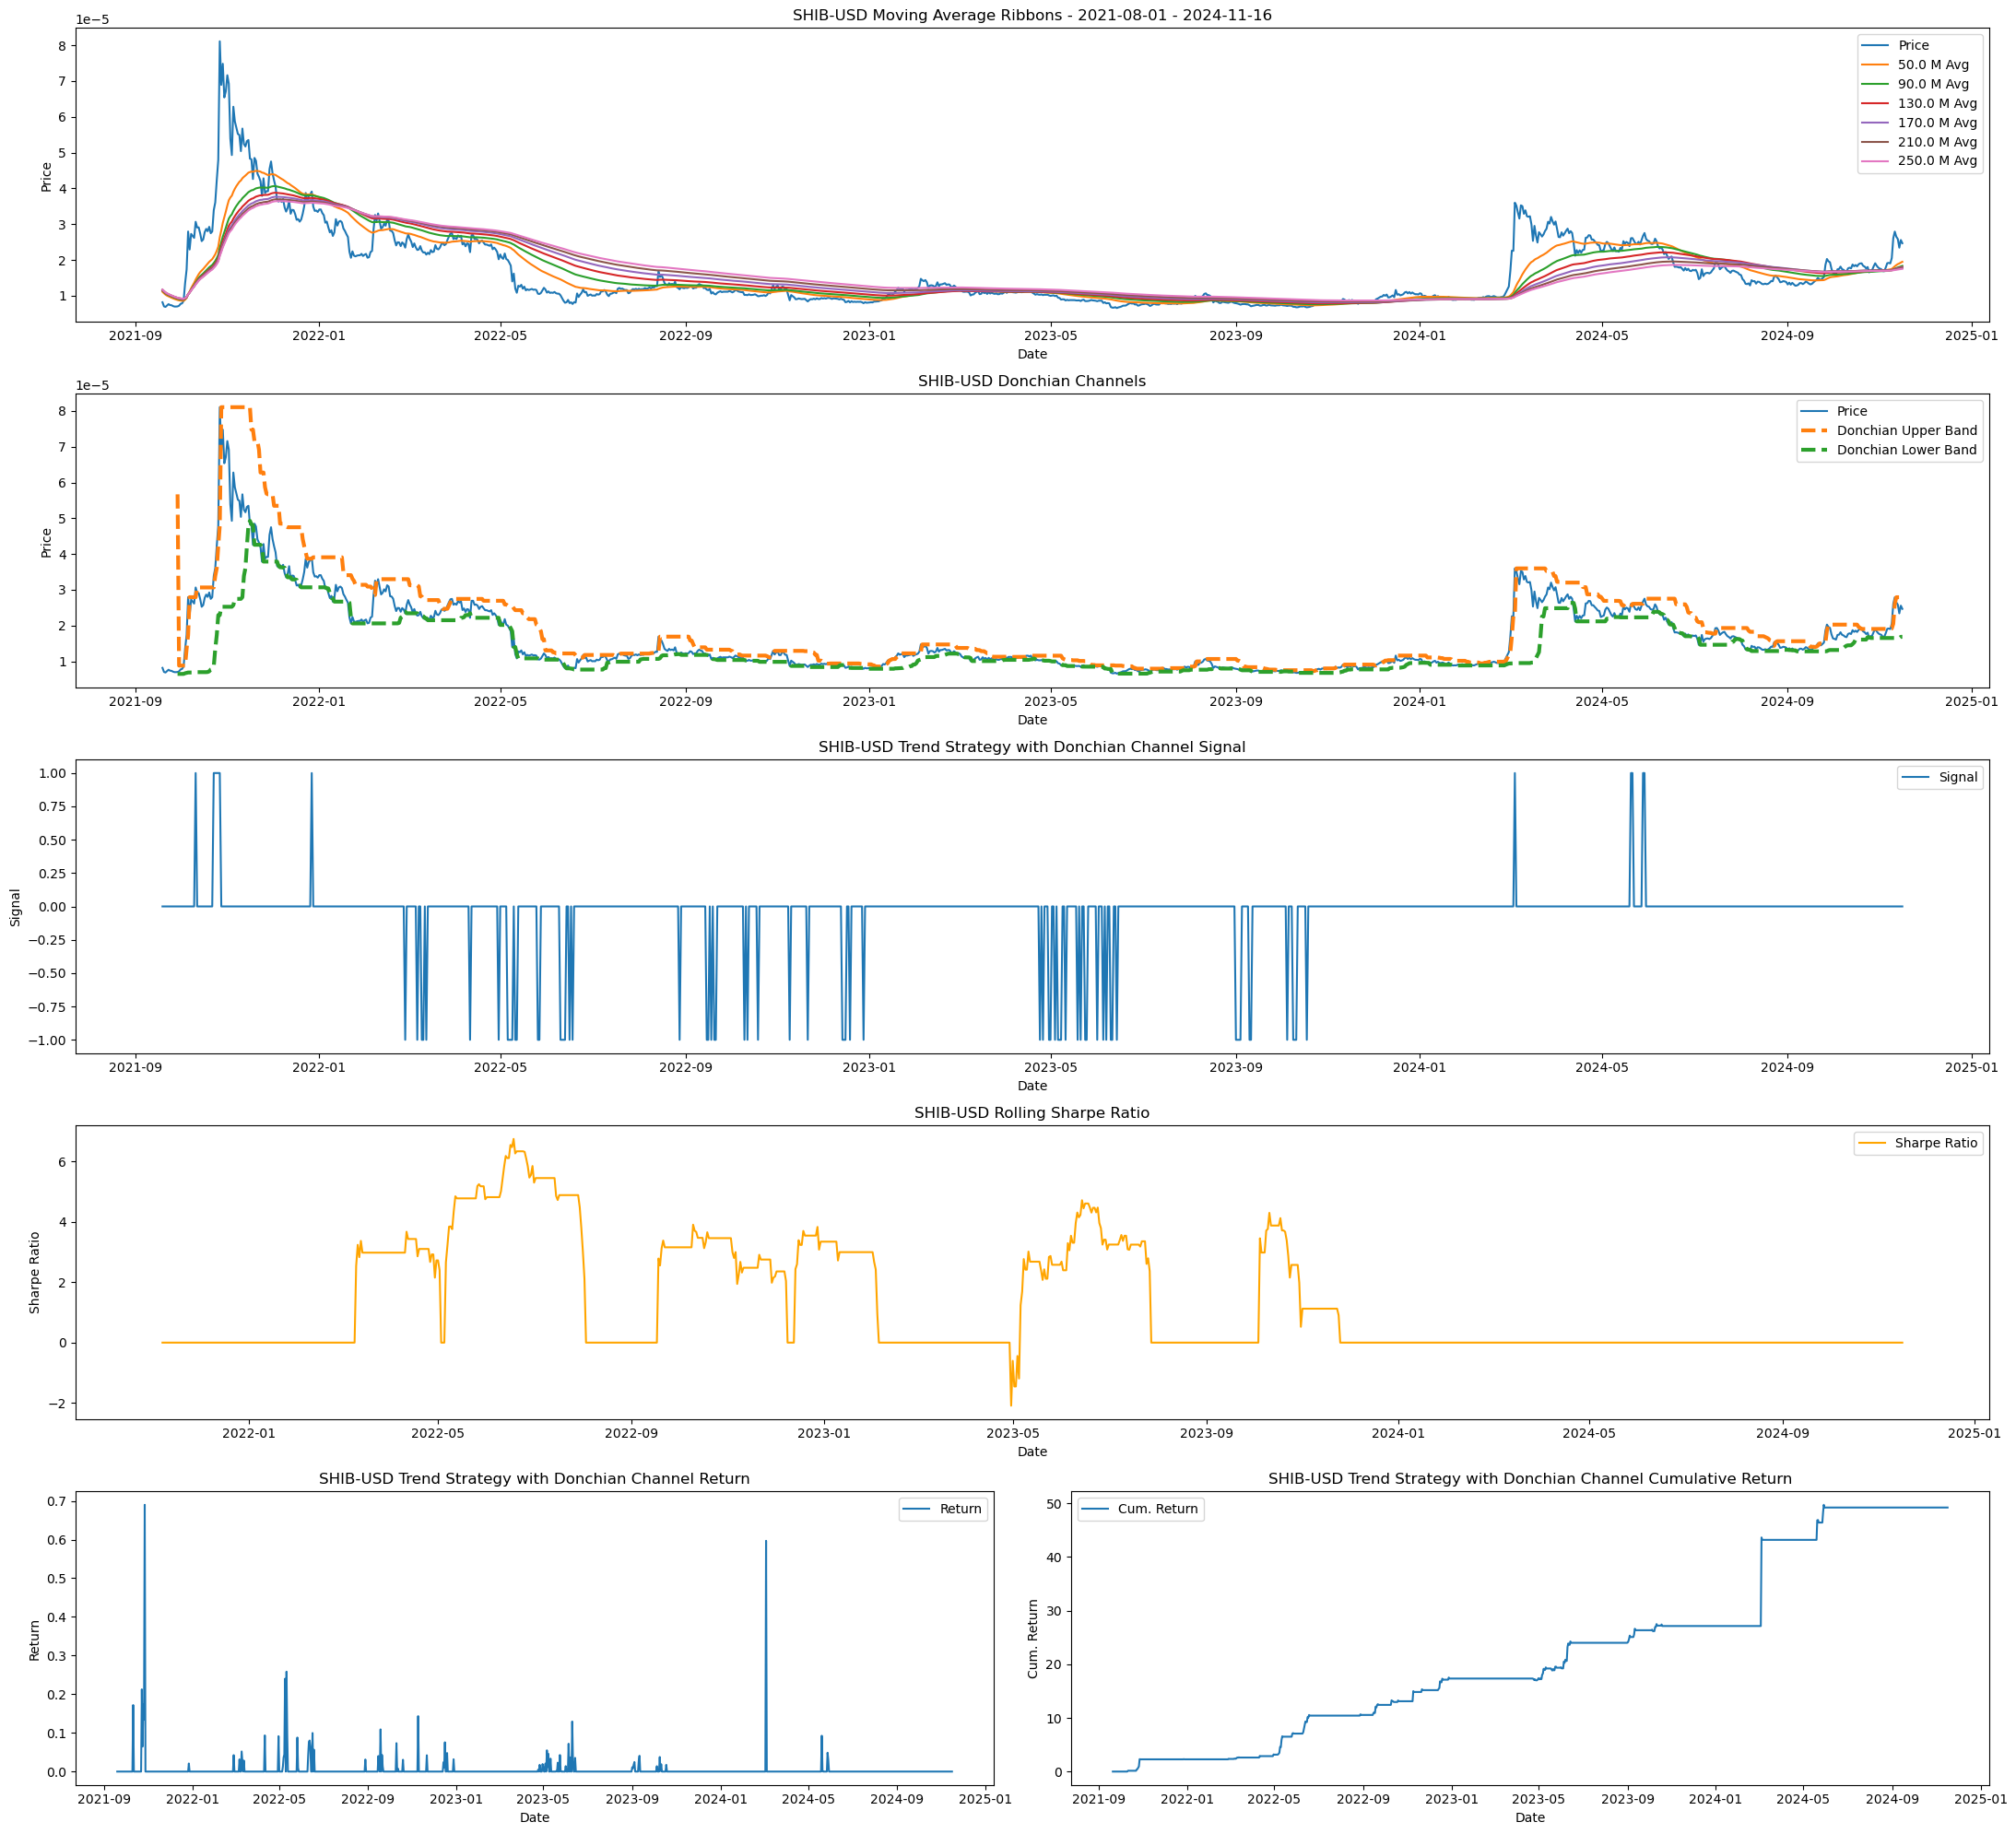

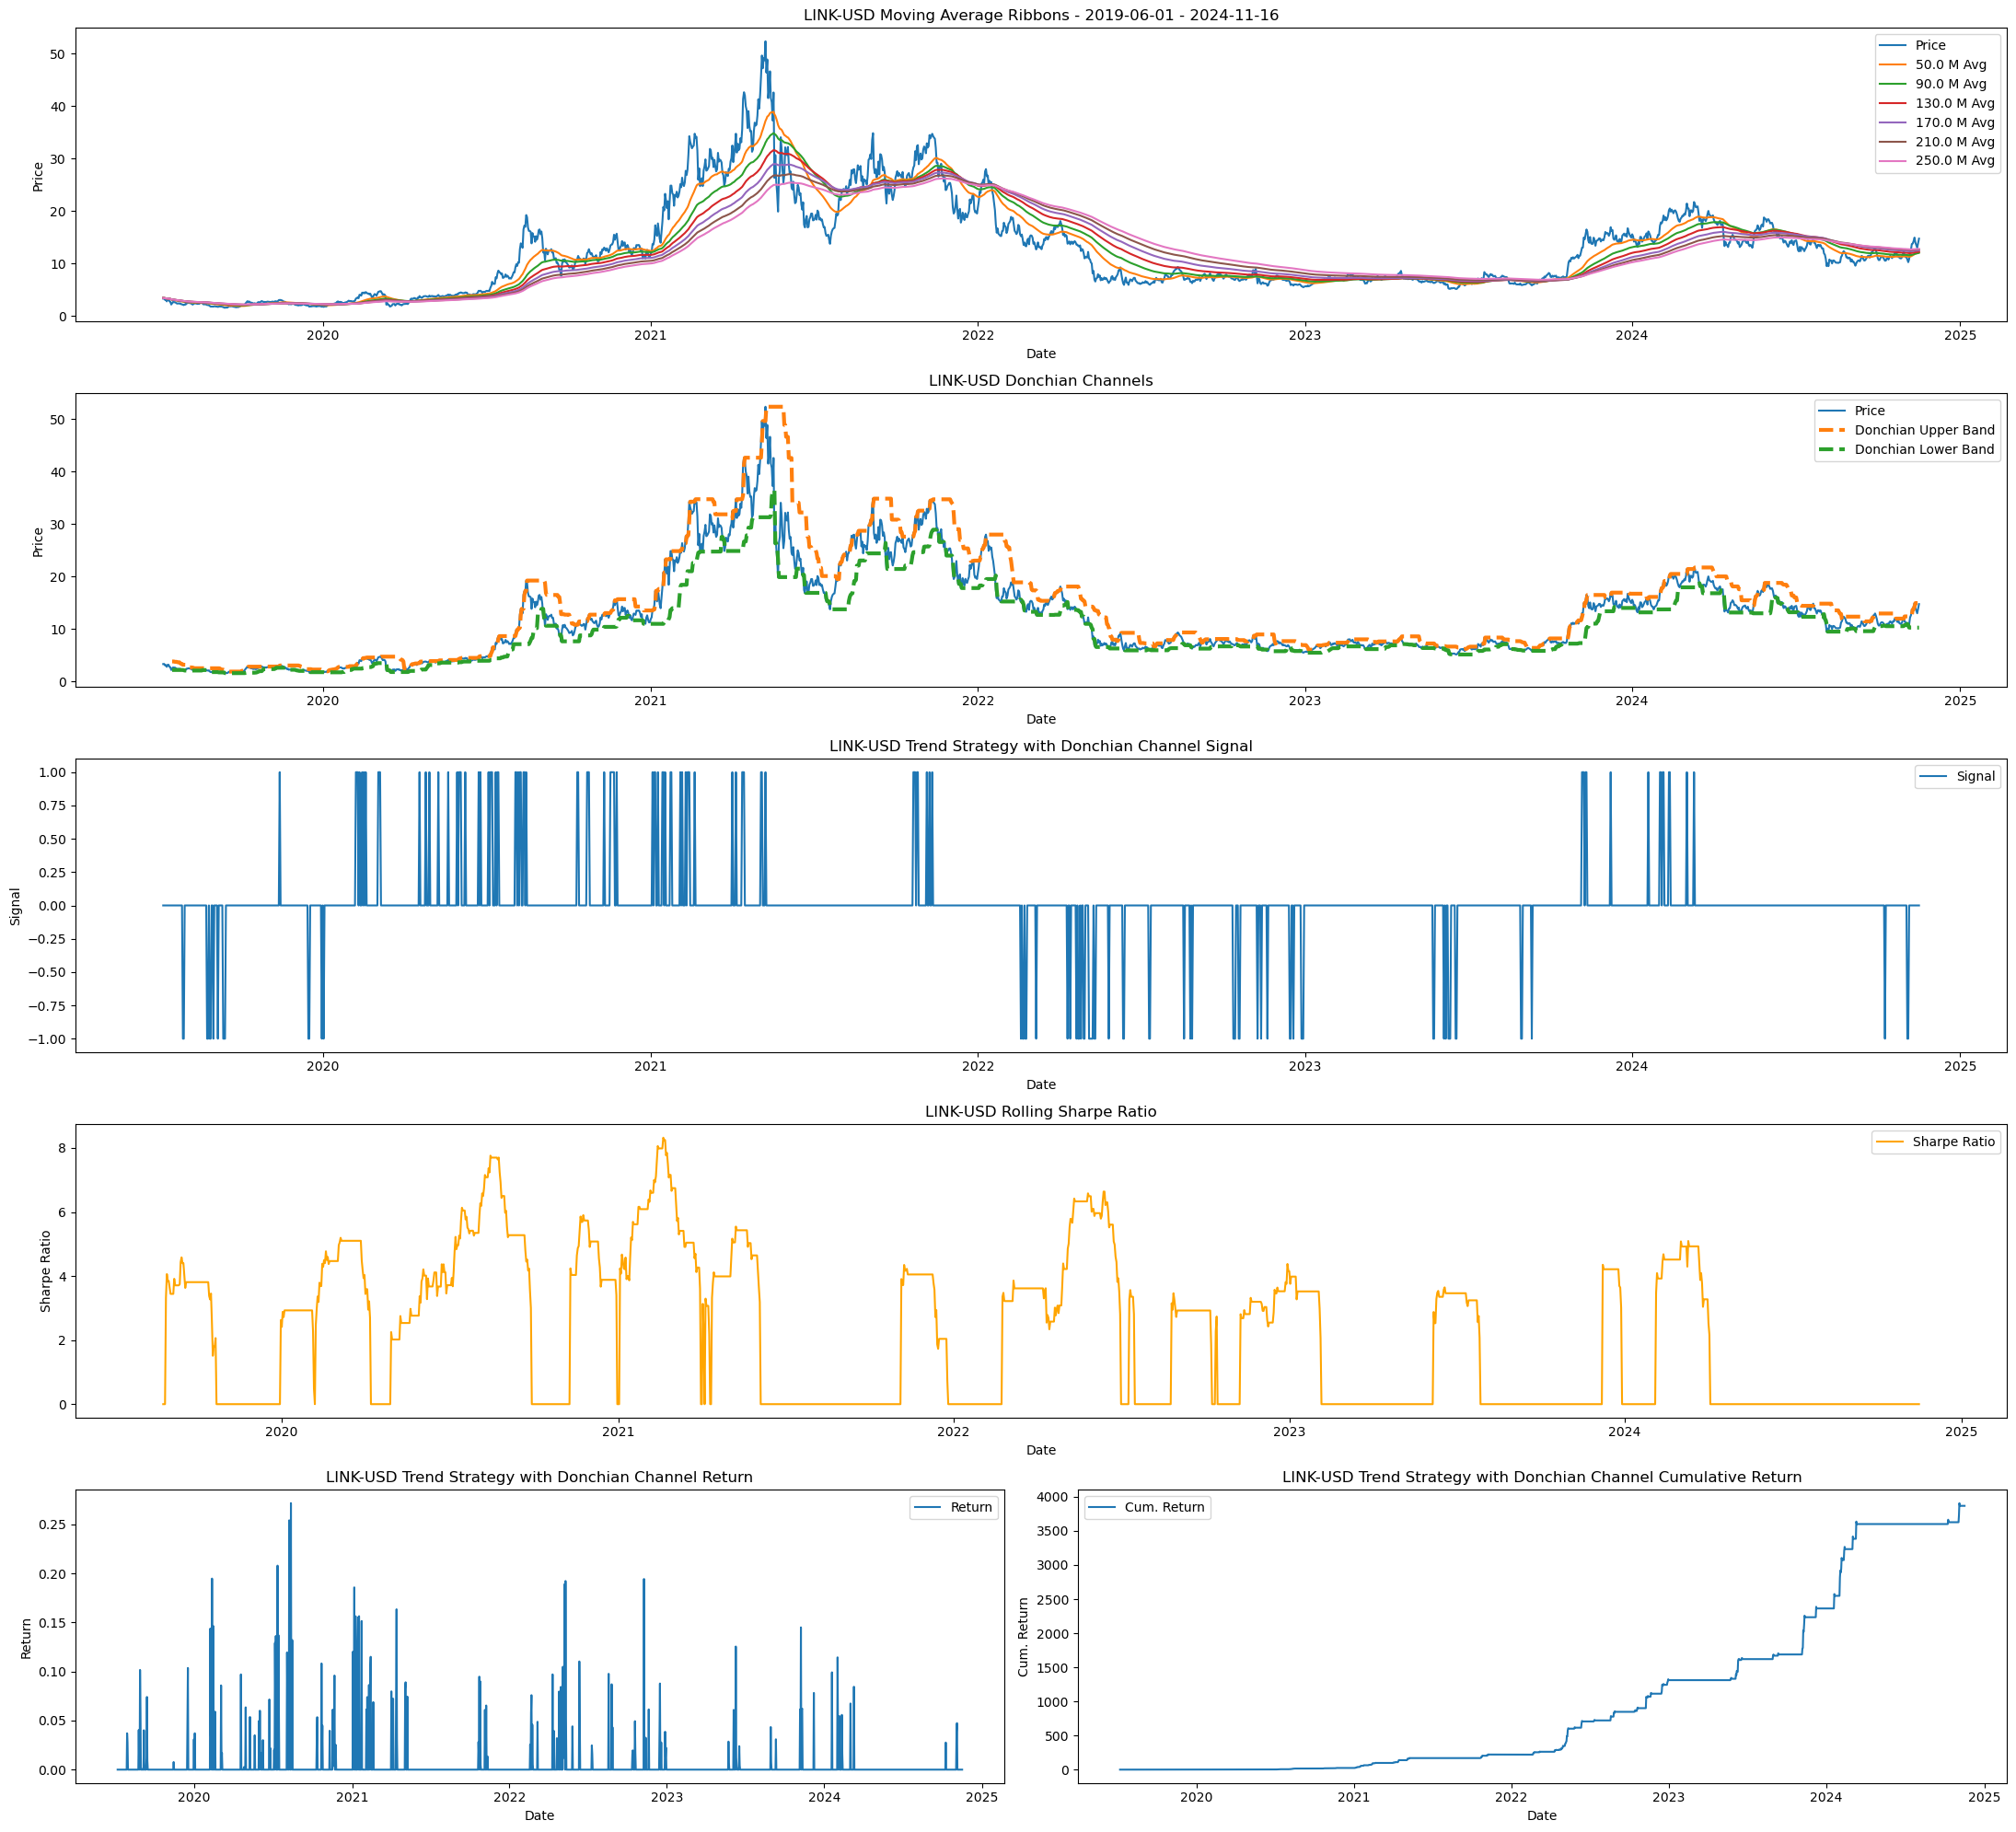

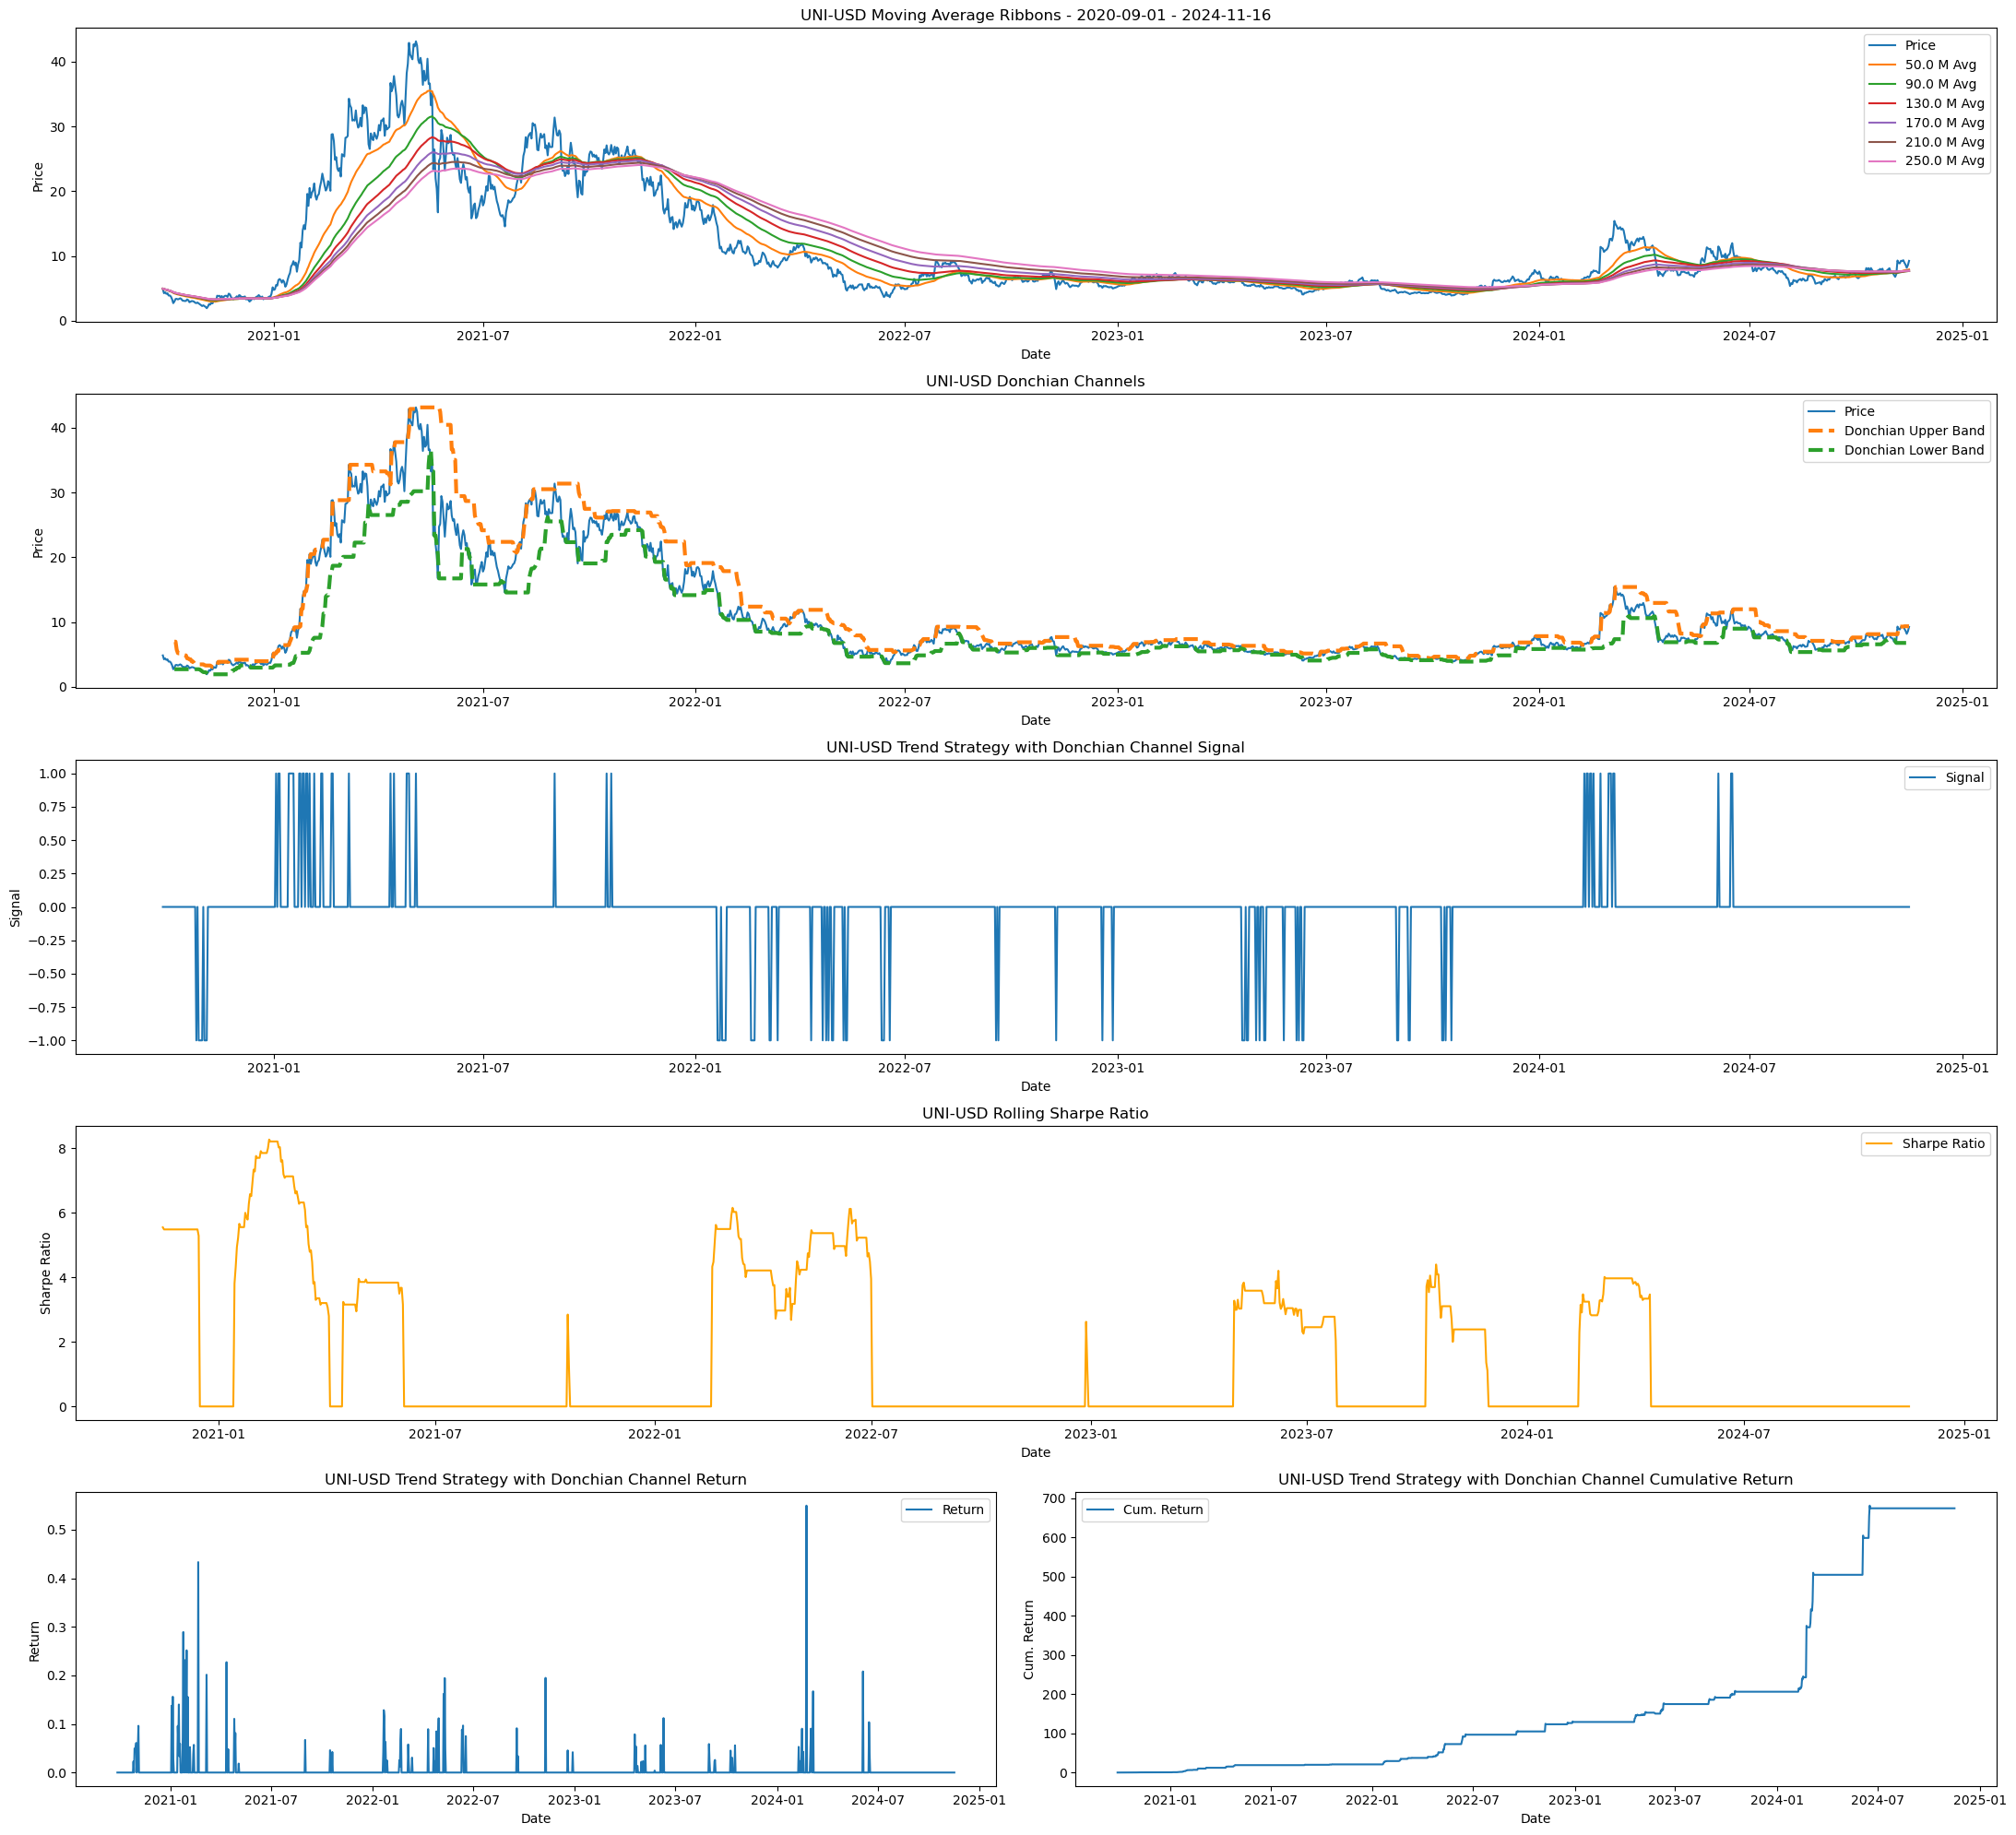

In [20]:
trend_df_dict = {}
ticker_list = ['BTC-USD','ETH-USD','SOL-USD','LTC-USD','DOGE-USD','CRO-USD','ADA-USD','AVAX-USD','XRP-USD','SHIB-USD','LINK-USD','UNI-USD']
start_date_dict = {
    'BTC-USD': '2016-01-01',
    'ETH-USD': '2016-05-01',
    'SOL-USD': '2021-06-01',
    'LTC-USD': '2021-08-01',
    'DOGE-USD': '2021-05-01',
    'CRO-USD': '2021-10-01',
    'ADA-USD': '2021-03-01',
    'AVAX-USD': '2021-09-01',
    'XRP-USD': '2023-06-01',
    'SHIB-USD': '2021-08-01',
    'LINK-USD': '2019-06-01',
    'UNI-USD': '2020-09-01',
}
end_date = datetime.datetime.now().date()#.strftime('%Y-%m-%d')
for ticker in ticker_list:
    print(ticker)
    _df_trend = get_trend_following_strategy_performance(start_date=pd.to_datetime(start_date_dict[ticker]).date(), end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                                                         mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, rolling_sharpe_window=50)
    trend_df_dict[ticker] = _df_trend

In [32]:
trend_df_dict['XRP-USD']#.shape

XRP-USD  XRP-USD_pct_returns  XRP-USD_50_mavg  \
date                                                        
2023-07-23   0.7382             0.007232         0.761125   
2023-07-24   0.7022            -0.048767         0.755064   
2023-07-25   0.7088             0.009399         0.750590   
2023-07-26   0.7162             0.010440         0.747445   
2023-07-27   0.7136            -0.003630         0.744504   
2023-07-28   0.7120            -0.002242         0.741807   
2023-07-29   0.7123             0.000421         0.739462   
2023-07-30   0.7049            -0.010389         0.736822   
2023-07-31   0.6977            -0.010214         0.733940   
2023-08-01   0.7066             0.012756         0.731993   
2023-08-02   0.6847            -0.030993         0.728730   
2023-08-03   0.6626            -0.032277         0.724299   
2023-08-04   0.6349            -0.041805         0.718471   
2023-08-05   0.6283            -0.010395         0.712741   
2023-08-06   0.6229            -0.008595         0.707168   
2023-08-07   0.6230             0.000161         0.702063   
2023-08-08   0.6418             0.030177         0.698485   
2023-08-09   0.6431             0.002026         0.695261   
2023-08-10   0.6324            -0.016638         0.691671   
2023-08-11   0.6309            -0.002372         0.688261   
2023-08-12   0.6272            -0.005865         0.684891   
2023-08-13   0.6251            -0.003348         0.681644   
2023-08-14   0.6336             0.013598         0.679073   
2023-08-15   0.6097            -0.037721         0.675413   
2023-08-16   0.5883            -0.035099         0.670879   
2023-08-17   0.5067            -0.138705         0.662442   
2023-08-18   0.5062            -0.000987         0.654510   
2023-08-19   0.5199             0.027064         0.647754   
2023-08-20   0.5383             0.035391         0.642320   
2023-08-21   0.5245            -0.025636         0.636531   
2023-08-22   0.5208            -0.007054         0.630900   
2023-08-23   0.5303             0.018241         0.626052   
2023-08-24   0.5185            -0.022252         0.620914   
2023-08-25   0.5256             0.013693         0.616400   
2023-08-26   0.5230            -0.004947         0.612012   
2023-08-27   0.5234             0.000765         0.607881   
2023-08-28   0.5227            -0.001337         0.603940   
2023-08-29   0.5398             0.032715         0.600992   
2023-08-30   0.5284            -0.021119         0.597679   
2023-08-31   0.5110            -0.032930         0.593748   
2023-09-01   0.4979            -0.025636         0.589428   
2023-09-02   0.4989             0.002008         0.585371   
2023-09-03   0.5047             0.011626         0.581776   
2023-09-04   0.5085             0.007529         0.578528   
2023-09-05   0.5054            -0.006096         0.575303   
2023-09-06   0.5032            -0.004353         0.572138   
2023-09-07   0.5049             0.003378         0.569201   
2023-09-08   0.5049             0.000000         0.566405   
2023-09-09   0.5039            -0.001981         0.563698   
2023-09-10   0.4968            -0.014090         0.560813   
2023-09-11   0.4743            -0.045290         0.557097   
2023-09-12   0.4803             0.012650         0.553810   
2023-09-13   0.4834             0.006454         0.550807   
2023-09-14   0.4892             0.011998         0.548189   
2023-09-15   0.5006             0.023303         0.546173   
2023-09-16   0.4999            -0.001398         0.544219   
2023-09-17   0.4927            -0.014403         0.542050   
2023-09-18   0.5032             0.021311         0.540419   
2023-09-19   0.5141             0.021661         0.539317   
2023-09-20   0.5213             0.014005         0.538565   
2023-09-21   0.5073            -0.026856         0.537263   
2023-09-22   0.5122             0.009659         0.536222   
2023-09-23   0.5077            -0.008786         0.535039   
2023-09-24   0.5020            -0.011227       

In [73]:
df_donchian = tf.calculate_donchian_channels(start_date=pd.to_datetime(start_date_dict['BTC-USD']).date(), end_date=end_date, ticker='BTC-USD')

In [81]:
df_donchian.tail(200)

low      high      open     close        volume  \
date                                                               
2024-04-15  62315.08  66928.82  65764.56  63452.18  21672.737013   
2024-04-16  61645.09  64400.00  63452.18  63814.94  17710.282132   
2024-04-17  59648.33  64524.14  63814.94  61279.36  21812.152979   
2024-04-18  60816.07  64210.00  61275.73  63513.85  15249.842114   
2024-04-19  59573.32  65498.99  63514.84  63848.37  22838.079342   
2024-04-20  63121.15  65463.08  63841.96  64968.87   5157.407265   
2024-04-21  64250.00  65725.81  64960.82  64952.92   4487.487232   
2024-04-22  64520.00  67272.73  64952.92  66859.17  10977.051786   
2024-04-23  65823.66  67225.66  66856.07  66414.16   8840.167498   
2024-04-24  63542.56  67077.97  66418.00  64255.78  15083.552435   
2024-04-25  62747.18  65287.69  64255.77  64484.44  13256.298777   
2024-04-26  63287.76  64810.00  64484.44  63742.39  10151.962477   
2024-04-27  62389.00  63900.00  63742.39  63422.00   5312.167413   
2024-04-28  62743.81  64333.33  63422.34  63108.94   4415.968316   
2024-04-29  61741.01  64200.00  63109.76  63844.85  10712.135543   
2024-04-30  59040.30  64727.81  63845.01  60622.10  21106.655408   
2024-05-01  56500.00  60785.49  60621.20  58265.59  26611.931273   
2024-05-02  56903.79  59641.03  58267.81  59071.89  13593.009059   
2024-05-03  58821.05  63365.72  59070.30  62913.03  15954.290327   
2024-05-04  62565.82  64546.00  62913.03  63902.88   6414.574644   
2024-05-05  62908.34  64636.75  63902.88  64023.45   4474.519592   
2024-05-06  62704.48  65523.44  64023.45  63162.24  11241.772173   
2024-05-07  62252.64  64415.06  63161.35  62315.76   8994.937730   
2024-05-08  60851.04  63013.05  62315.75  61169.53   7486.425968   
2024-05-09  60601.60  63424.14  61169.53  63073.57   8360.055382   
2024-05-10  60150.00  63470.00  63073.55  60787.47  11511.129910   
2024-05-11  60450.13  61482.00  60787.99  60814.63   2338.068108   
2024-05-12  60576.05  61843.45  60814.64  61453.02   2694.975779   
2024-05-13  60738.51  63456.18  61453.01  62932.37   9170.808651   
2024-05-14  61024.51  63103.02  62927.44  61539.84  13456.613076   
2024-05-15  61299.57  66480.00  61539.70  66244.69  21821.388587   
2024-05-16  64588.50  66772.83  66244.68  65252.18  12012.701972   
2024-05-17  65113.46  67500.00  65252.17  67046.33  11710.007239   
2024-05-18  66624.06  67407.79  67046.34  66923.87   3880.581140   
2024-05-19  65852.02  67701.91  66923.87  66261.62   3565.113462   
2024-05-20  66057.03  71560.90  66260.04  71432.17  20415.886917   
2024-05-21  69146.01  71980.00  71432.16  70142.84  16102.061325   
2024-05-22  68887.52  70659.99  70142.88  69109.93  10889.103009   
2024-05-23  66259.00  70066.95  69109.93  67940.45  14340.278436   
2024-05-24  66587.91  69278.75  67932.79  68547.80  10374.959881   
2024-05-25  68487.44  69605.03  68545.52  69289.67   2501.119020   
2024-05-26  68097.38  69522.00  69289.69  68473.72   2037.673291   
2024-05-27  68210.12  70613.39  68470.80  69368.72   5384.622781   
2024-05-28  67194.59  69533.96  69366.31  68321.98  11975.930863   
2024-05-29  67081.66  68864.11  68321.99  67569.45   8970.020591   
2024-05-30  67092.91  69536.89  67569.44  68338.58  11841.263819   
2024-05-31  66584.47  69024.71  68338.58  67472.41  10690.858762   
2024-06-01  67371.28  67837.33  67473.07  67719.29   1949.570081   
2024-06-02  67260.00  68411.00  67719.29  67735.52   2997.152415   
2024-06-03  67568.00  70295.78  67731.14  68791.00  11884.908827   
2024-06-04  68542.37  71108.90  68791.04  70542.32  18042.193965   
2024-06-05  70356.49  71804.13  70541.68  71121.11  10123.180292   
2024-06-06  70093.98  71650.56  71120.65  70773.64   7716.507999   
2024-06-07  68298.55  71974.04  70773.63  69324.53  13768.981853   
2024-06-08  69126.22  69546.58  69326.71  69304.05   2631.946104   
2024-06-09  69123.99  69848.94  69303.80  69637.87   1826.039955   
2024-06-10  69141.51  70187.53  69641.08  69497.73   6088.403632   
2024-